# compare different strategies for computing the oligomeric state of proteins 

In [1]:
# imports 
import pandas as pd 
import pickle
import glob
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval

Read in files

In [2]:
# read in the set of phrogs that we want to use for threshold selection
# Get the phrogs that pass the length and plddt filters 
with open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_alphafold_trained.txt', 'r') as file:
    phrogs_pass_alphafold_seen =  [line.strip() for line in file]

# read in the ones that haven't been seen by alphafold
with open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_validation_alphafold_unseen.txt', 'r') as file:
    phrogs_pass_alphafold_unseen =  [line.strip() for line in file]
    
# read in the manually curated monomers 
manual_monomers = pd.read_csv('/home/grig0076/GitHubs/phlegm/files/manual_monomer_curation_20250723.csv')
manual_monomers_phrogs = manual_monomers.dropna()['PHROG'].to_list() 

# read in the oligomeric state of these as deposited in the pdb 
alphafold_known_state = pickle.load(open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_oligomeric_state.pkl', 'rb'))

# large oligomers - I have a table in the supp info that contains this information 
large_oligomeric_manual = {'phrog_45': 'Homo 6-mer', 
'phrog_659': 'Homo 18-mer', 
'phrog_55': 'Homo 6-mer', 
'phrog_33753': 'Homo 35-mer',
'phrog_36144': '8-mer', 
'phrog_38392': '24-mer', 
'phrog_432': '2-mer', 
'phrog_267': 'Homo 6-mer', # also pentameric - but these are grouped together for classification
'phrog_247': 'Homo 6-mer', # also pentameric - but these are grouped together for classification 
'phrog_371': 'Homo 6-mer',  # also pentameric - but these are grouped together for classification
'phrog_16897': 'Homo 20-mer'}

## Dictionaries for mapping the oligomeric state of proteins 

In [3]:
# group the nubmer of subunits into a bin 
state_bins_dict = {'Monomer': 'Monomer', 
  '2-mer': '2-mer', 
 'Homo 2-mer': '2-mer', 
'Homo 3-mer': '3-mer', 
'Homo 4-mer': '4-mer', 
'Homo 5-mer': '5-6-mer', 
'Homo 6-mer': '5-6-mer',
'Homo 7-mer': '7+-mer',
 '8-mer': '7+-mer',
'Homo 8-mer': '7+-mer',
'Homo 9-mer': '7+-mer',
'Homo 10-mer': '7+-mer',
 'Homo 12-mer': '7+-mer',
 'Homo 18-mer': '7+-mer',
  'Homo 20-mer': '7+-mer',
   '24-mer': '7+-mer',
    'Homo 35-mer': '7+-mer'
}

# Map oligomeric states to their correct number of subunits
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    '2-mer': 2, 
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    '8-mer': 8, 
    'Homo 9-mer': 9,
    'Homo 10-mer': 10,
    'Homo 35-mer': 35, 
    'Homo 12-mer': 12, 
    'Homo 18-mer': 18, 
    'Homo 20-mer':20
}

subunits_state_dict = {1: 'Monomer', 
  2: '2-mer',  
3: '3-mer', 
4: '4-mer', 
5: '5-6-mer', 
6: '5-6-mer',
7: '7+-mer',
8: '7+-mer',
9: '7+-mer',
10: '7+-mer',
}


In [4]:
# apply criteria to filter this dictionary 
keys = list(alphafold_known_state.keys())

phrogs_pass_alphafold_seen_state = dict()
phrogs_pass_alphafold_seen_state_bin = dict()
labelled_monomers = [] # flag the monomers as these require manual curation 

for k in keys: 
    
    # see if phrog has been curated as a Monomer manually
    # nothing is happening here at the moment - not currently incorporating the manual check 

    if list(alphafold_known_state.get(k).keys()) == ['Monomer']: # this here is if it is only ever listed as a monomer 
        
        # only if in the manually curated set 
        if k in manual_monomers_phrogs:
            phrogs_pass_alphafold_seen_state[k] = 'Monomer'
            phrogs_pass_alphafold_seen_state_bin[k] = 'Monomer'
            labelled_monomers.append(k)
    
    # otherwise look at pdb hits 
    else: 
        states = alphafold_known_state.get(k)

        # correct any keys in states that mention more than one state
        double_keys = [s for s in list(states.keys()) if '\'' in s] 
        if len(double_keys) > 0: 

            for j in double_keys: 
                split = re.split(', ', j) 
                for s in split: 
                    if s in list(states.keys()):
                        states[s.replace('\'', '')] += 1
                    else: 
                        states[s.replace('\'', '')] = 1

                del states[j]

    
        # Delete monomers from the states dictionary - if there is a high state this is more likely 
        if 'Monomer' in list(states.keys()):
            del states['Monomer']
            
            
        # TODO return here to see if there are any missing from the manual curation 
        
        # apply criteria that there shouldn't be more than 3 possible states 
        if len(states) > 3: 
            phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
        
        # check that the 'winning' state represents at least 70% of the hits 
        else: 
            
            if len(states) > 0: 
                
                if k in list(large_oligomeric_manual.keys()): 
                    phrogs_pass_alphafold_seen_state[k] = large_oligomeric_manual.get(k)
                    phrogs_pass_alphafold_seen_state_bin[k] = state_bins_dict.get(large_oligomeric_manual.get(k))
                    if state_bins_dict.get(large_oligomeric_manual.get(k)) == None: 
                        print(k)
                
                else:
                    # generate a dataframe with number of hits to each state
                    hits_df = pd.DataFrame.from_dict(states, orient='index').sort_values(0, ascending=False)

                    # compute the 'dominance' of this top state 
                    dominance = hits_df.iloc[0]/hits_df[0].sum()

                    if dominance[0] >= 0.65: 
                        phrogs_pass_alphafold_seen_state[k] = hits_df.index[0]
                        phrogs_pass_alphafold_seen_state_bin[k] = state_bins_dict.get(hits_df.index[0])
                        
                    else: 
                        phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
     

In [5]:
# count the number with a known state amongst everything 
Counter(list(phrogs_pass_alphafold_seen_state_bin.values())) # this here is the number in the curate phrogs group 

Counter({'3-mer': 25,
         '2-mer': 196,
         '7+-mer': 20,
         'Monomer': 36,
         '5-6-mer': 32,
         '4-mer': 34})

In [6]:
# read in the metrics generated for the phrogs that pass the tests 
part_1 =  glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_001.phlegm/metrics_pickle/*.pkl')
part_2 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_002.phlegm/metrics_pickle/*.pkl')
part_3 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_003.phlegm/metrics_pickle/*.pkl')
part_4 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_004.phlegm/metrics_pickle/*.pkl')
part_5 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_005.phlegm/metrics_pickle/*.pkl')
part_6 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_006.phlegm/metrics_pickle/*.pkl') 
part_7 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_007.phlegm/metrics_pickle/*.pkl')
part_8 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_008.phlegm/metrics_pickle/*.pkl')
all_parts =  part_1 + part_2 + part_3 + part_4 + part_5 + part_6 + part_7 + part_8

all_phrogs_pickle_complete = [re.split('/', p)[-1][:-4] for p in all_parts]

# filter these to only inlucde the ones that pass the plddt cutoff 
all_phrogs_alphafold_seen_complete = list(set(all_phrogs_pickle_complete).intersection(set(phrogs_pass_alphafold_seen))) 

# generate 'seen' set which alphafold has seen during training as a discovery set 
all_phrogs_pickle_complete_seen = np.array(all_phrogs_alphafold_seen_complete)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_alphafold_seen_complete ]]
all_phrogs_pickle_complete_seen_path = np.array(all_parts)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_pickle_complete]]

# generate an 'unseen' set which alphafold has not seen during training as a validation set
all_phrogs_alphafold_unseen_complete = list(set(all_phrogs_pickle_complete).intersection(set(phrogs_pass_alphafold_unseen))) 

all_phrogs_pickle_complete_unseen = np.array(all_phrogs_alphafold_unseen_complete)[[True if a in phrogs_pass_alphafold_unseen else False for a in all_phrogs_alphafold_unseen_complete ]]
all_phrogs_pickle_complete_unseen_path = np.array(all_parts)[[True if a in phrogs_pass_alphafold_unseen else False for a in all_phrogs_pickle_complete]]


# make a dictionary that maps the phrog to its metrics path 
pickle_paths = dict(zip(all_phrogs_pickle_complete, all_parts))

For the phlegm method extract metrics to make predictions 

In [7]:
# loop through the discovery phrogs to make a dataframe 
subunits_keys = ['2_subunits', '3_subunits', '4_subunits', '5_subunits', '6_subunits', '7_subunits', '8_subunits', '9_subunits', '10_subunits'] 
replicate_keys = ['rep_1', 'rep_2', 'rep_3'] # update to all 5 later
metrics_df = pd.DataFrame()

for p in  list(phrogs_pass_alphafold_seen_state.keys()):
    
    metrics = pickle.load(open(pickle_paths.get(p), 'rb'))

    for s in subunits_keys: 
        for r in replicate_keys: 
            m = metrics.get(s).get(r) 
            iptm = m.get('iptm')  
            ptm = m.get('ptm')
            mean_plddt = m.get('mean_plddt')
            mean_pdockq2 = np.mean(m.get('pdockq2'))
            mean_plddt_lst = np.mean(m.get('avgif_pae'))
            df = pd.DataFrame.from_dict({'iptm': iptm, 'ptm': ptm, 'mean_plddt':mean_plddt, 'mean_pdockq2': mean_pdockq2, 'mean_plddt_lst': mean_plddt_lst}, orient='index').T
            df['replicate'] = r
            df['subunits'] = str(int(re.split('_', s)[0]))
            df['state_bin'] = state_bins_dict.get(phrogs_pass_alphafold_seen_state.get(p))
            df['phrog'] = p

            metrics_df = pd.concat([metrics_df, df])

In [39]:
phrog_807[phrog_807['subunits'] == '6']['iptm'].mean()

0.7466666666666667

In [35]:
phrog_807

,iptm,ptm,mean_plddt,mean_pdockq2,mean_plddt_lst,replicate,subunits,state_bin,phrog
0,0.36,0.44,64.474277,0.012089,0.278144,rep_1,2,5-6-mer,phrog_807
0,0.33,0.42,60.134570,0.011649,0.295650,rep_2,2,5-6-mer,phrog_807
0,0.11,0.33,65.177598,0.008912,0.173858,rep_3,2,5-6-mer,phrog_807
0,0.45,0.53,68.503438,0.020408,0.418401,rep_1,3,5-6-mer,phrog_807
0,0.38,0.49,68.152031,0.012001,0.255698,rep_2,3,5-6-mer,phrog_807
0,0.36,0.45,64.969531,0.013172,0.315607,rep_3,3,5-6-mer,phrog_807
0,0.45,0.52,72.468086,0.024981,0.436990,rep_1,4,5-6-mer,phrog_807
0,0.45,0.51,69.508711,0.021835,0.428771,rep_2,4,5-6-mer,phrog_807
0,0.42,0.50,73.187090,0.016977,0.341272,rep_3,4,5-6-mer,phrog_807
0,0.63,0.68,80.037422,0.099785,0.666218,rep_1,5,5-6-mer,phrog_807


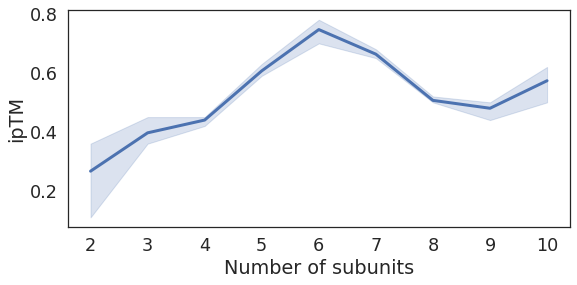

In [42]:
phrog_807 = metrics_df[metrics_df['phrog'] == 'phrog_807'] 

sns.set(style='white', font_scale=1.6)
plt.figure(figsize=(9, 4))
sns.lineplot(data=phrog_807, x='subunits', y='iptm', linewidth=3)
plt.xlabel('Number of subunits')
plt.ylabel('ipTM')
plt.savefig('../figures/phrog_807_plot.png',  dpi=300, bbox_inches='tight')
plt.show()

In [9]:
phrogs_predict = list(set(metrics_df['phrog']))

# store this info in a dataframe like the others so that a prediction can be made 
iptm_predictions = pd.DataFrame() 

for p in phrogs_predict: 
    
    dd = metrics_df[metrics_df['phrog'] == p] 
    per_subunits_iptm = dd[['iptm', 'subunits', 'mean_plddt']].groupby('subunits').mean() 
    max_iptm = per_subunits_iptm.max()[0] 
    max_iptm_subunits = int(per_subunits_iptm.idxmax()[0])
    max_iptm_subunits_plddt = per_subunits_iptm.loc[per_subunits_iptm.idxmax()[0]]['mean_plddt'] # get the plddt of this prediction 
    
    # if this max is below a threshold then say it is a monomer/can't be predicted  
    if max_iptm<0.5 or max_iptm_subunits_plddt < 60: 
        max_iptm_subunits = 1
        
    results = pd.DataFrame.from_dict({'phrog': p, 'max_iptm': max_iptm, 'max_iptm_subunits': max_iptm_subunits, 'curated_state_bin': dd['state_bin'].iloc[0], 'prediction_state_bin': subunits_state_dict.get(max_iptm_subunits) }, orient='index').T
    iptm_predictions = pd.concat([iptm_predictions, results])
    
# Create column indicating whether prediction was correct
iptm_predictions['is_correct'] = iptm_predictions['curated_state_bin'] == iptm_predictions['prediction_state_bin']

# Optional: short label
iptm_predictions['correct_label'] = iptm_predictions['is_correct'].map({True: "Correct", False: "Incorrect"})

# drop the predictions that are ambiguous 
iptm_predictions = iptm_predictions.dropna()

In [10]:
iptm_predictions

,phrog,max_iptm,max_iptm_subunits,curated_state_bin,prediction_state_bin,is_correct,correct_label
0,phrog_16458,0.55,4,5-6-mer,4-mer,False,Incorrect
0,phrog_1143,0.69,10,Monomer,7+-mer,False,Incorrect
0,phrog_10132,0.426667,1,2-mer,Monomer,False,Incorrect
0,phrog_13721,0.913333,2,2-mer,2-mer,True,Correct
0,phrog_33519,0.17,1,2-mer,Monomer,False,Incorrect
...,...,...,...,...,...,...,...
0,phrog_4964,0.883333,2,2-mer,2-mer,True,Correct
0,phrog_33753,0.16,1,7+-mer,Monomer,False,Incorrect
0,phrog_32003,0.876667,2,2-mer,2-mer,True,Correct
0,phrog_11528,0.93,2,4-mer,2-mer,False,Incorrect


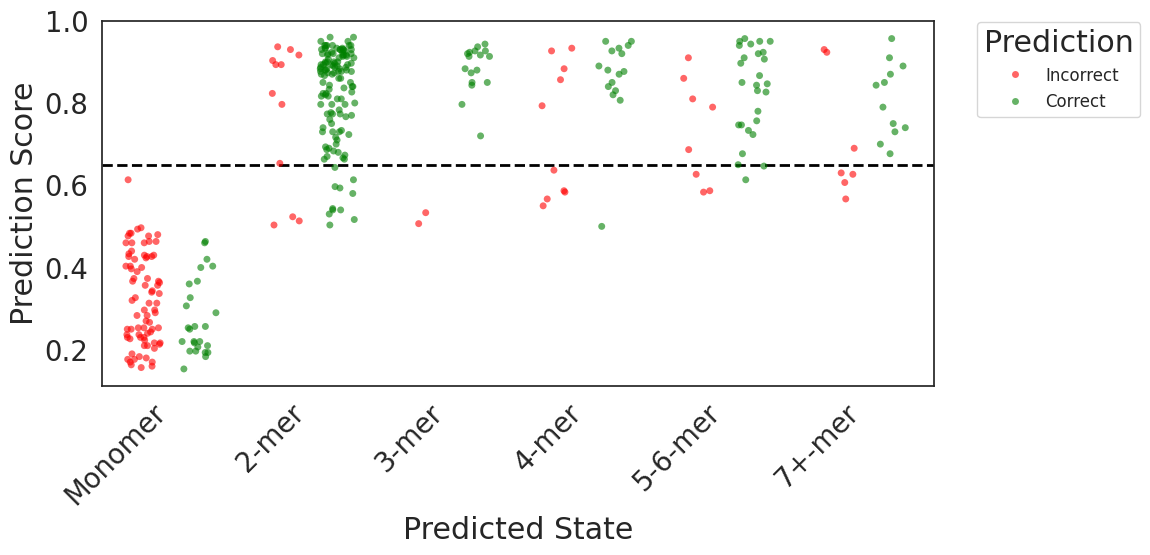

In [11]:
sns.set(style='white', font_scale=1.8)
plt.figure(figsize=(12, 6))

desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer'] 

# Create the stripplot
sns.stripplot(data=iptm_predictions, x='prediction_state_bin', y='max_iptm', hue='correct_label', dodge=True, jitter=0.25, alpha=0.6,
              palette={'Correct': 'green', 'Incorrect': 'red'},
              order=desired_order)

# Add dashed line at y=0.7
plt.axhline(y=0.65, color='black', linestyle='--', linewidth=2)

# Add legend
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/phlegm_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()


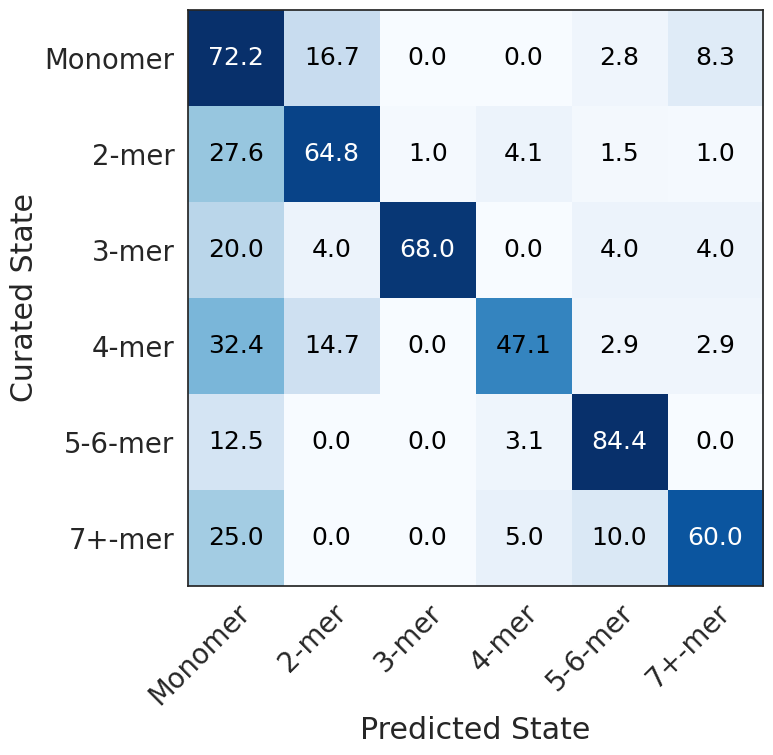

In [12]:
# make a confusion matrix of the predictions 
# Filter ambiguous rows (optional)
df = iptm_predictions[iptm_predictions['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['prediction_state_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)
# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Set color based on the score (adjust threshold if needed)
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/phelgm_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()
 

### investigate the incorrect predictions using the ipTM score

## PHLEGM Predictions on Unseen (Validation) Dataset

Now let's apply the PHLEGM method to the unseen dataset (proteins not seen during AlphaFold training) to validate the method's performance on truly independent data.

In [12]:
# Create oligomeric state dictionary for unseen proteins 
# Filter the alphafold_known_state dictionary to only include unseen proteins
phrogs_pass_alphafold_unseen_state = dict()
phrogs_pass_alphafold_unseen_state_bin = dict()
labelled_monomers_unseen = []

for k in alphafold_known_state.keys():
    if k in phrogs_pass_alphafold_unseen:
        
        # Check if phrog has been curated as a Monomer manually
        if list(alphafold_known_state.get(k).keys()) == ['Monomer']: 
            if k in manual_monomers_phrogs:
                phrogs_pass_alphafold_unseen_state[k] = 'Monomer'
                phrogs_pass_alphafold_unseen_state_bin[k] = 'Monomer'
                labelled_monomers_unseen.append(k)
        
        # Otherwise look at pdb hits 
        else: 
            states = alphafold_known_state.get(k).copy()

            # Correct any keys in states that mention more than one state
            double_keys = [s for s in list(states.keys()) if '\'' in s] 
            if len(double_keys) > 0: 
                for j in double_keys: 
                    split = re.split(', ', j) 
                    for s in split: 
                        if s in list(states.keys()):
                            states[s.replace('\'', '')] += 1
                        else: 
                            states[s.replace('\'', '')] = 1
                    del states[j]

            # Delete monomers from the states dictionary
            if 'Monomer' in list(states.keys()):
                del states['Monomer']
                
            # Apply criteria that there shouldn't be more than 3 possible states 
            if len(states) > 3: 
                phrogs_pass_alphafold_unseen_state[k] = 'ambiguous'
            
            # Check that the 'winning' state represents at least 65% of the hits 
            else: 
                if len(states) > 0: 
                    if k in list(large_oligomeric_manual.keys()): 
                        phrogs_pass_alphafold_unseen_state[k] = large_oligomeric_manual.get(k)
                        phrogs_pass_alphafold_unseen_state_bin[k] = state_bins_dict.get(large_oligomeric_manual.get(k))
                    
                    else:
                        # Generate a dataframe with number of hits to each state
                        hits_df = pd.DataFrame.from_dict(states, orient='index').sort_values(0, ascending=False)

                        # Compute the 'dominance' of this top state 
                        dominance = hits_df.iloc[0]/hits_df[0].sum()

                        if dominance[0] >= 0.65: 
                            phrogs_pass_alphafold_unseen_state[k] = hits_df.index[0]
                            phrogs_pass_alphafold_unseen_state_bin[k] = state_bins_dict.get(hits_df.index[0])
                            
                        else: 
                            phrogs_pass_alphafold_unseen_state[k] = 'ambiguous'

print(f"Number of unseen proteins with known oligomeric states: {len(phrogs_pass_alphafold_unseen_state)}")
print(f"Distribution of unseen protein states:")
print(Counter(list(phrogs_pass_alphafold_unseen_state_bin.values())))

Number of unseen proteins with known oligomeric states: 31
Distribution of unseen protein states:
Counter({'5-6-mer': 9, '2-mer': 8, 'Monomer': 4, '7+-mer': 4, '4-mer': 3, '3-mer': 2})


In [19]:
# Extract metrics for unseen proteins to make PHLEGM predictions
unseen_metrics_df = pd.DataFrame()

for p in list(phrogs_pass_alphafold_unseen_state.keys()):
    
    # Check if we have metrics for this protein
    if p in pickle_paths:
        metrics = pickle.load(open(pickle_paths.get(p), 'rb'))

        for s in subunits_keys: 
            for r in replicate_keys: 
                m = metrics.get(s).get(r) 
                iptm = m.get('iptm')  
                ptm = m.get('ptm')
                mean_plddt = m.get('mean_plddt')
                mean_pdockq2 = np.mean(m.get('pdockq2'))
                mean_plddt_lst = np.mean(m.get('avgif_pae'))
                df = pd.DataFrame.from_dict({'iptm': iptm, 'ptm': ptm, 'mean_plddt':mean_plddt, 'mean_pdockq2': mean_pdockq2, 'mean_plddt_lst': mean_plddt_lst}, orient='index').T
                df['replicate'] = r
                df['subunits'] = str(int(re.split('_', s)[0]))
                df['state_bin'] = state_bins_dict.get(phrogs_pass_alphafold_unseen_state.get(p))
                df['phrog'] = p

                unseen_metrics_df = pd.concat([unseen_metrics_df, df])

print(f"Number of unseen proteins with complete metrics: {len(unseen_metrics_df['phrog'].unique())}")
print(f"Total rows in unseen metrics dataframe: {len(unseen_metrics_df)}")

Number of unseen proteins with complete metrics: 31
Total rows in unseen metrics dataframe: 837


In [21]:
# Make PHLEGM predictions on unseen dataset
unseen_phrogs_predict = list(set(unseen_metrics_df['phrog']))
unseen_iptm_predictions = pd.DataFrame() 

for p in unseen_phrogs_predict: 
    
    dd = unseen_metrics_df[unseen_metrics_df['phrog'] == p] 
    per_subunits_iptm = dd[['iptm', 'subunits', 'mean_plddt']].groupby('subunits').mean() 
    max_iptm = per_subunits_iptm.max()[0] 
    max_iptm_subunits = int(per_subunits_iptm.idxmax()[0])
    max_iptm_subunits_plddt = per_subunits_iptm.loc[per_subunits_iptm.idxmax()[0]]['mean_plddt']
    
    # Apply the same thresholds as the seen dataset
    if max_iptm < 0.5 or max_iptm_subunits_plddt < 60: 
        max_iptm_subunits = 1
        
    results = pd.DataFrame.from_dict({
        'phrog': p, 
        'max_iptm': max_iptm, 
        'max_iptm_subunits': max_iptm_subunits, 
        'curated_state_bin': dd['state_bin'].iloc[0], 
        'prediction_state_bin': subunits_state_dict.get(max_iptm_subunits)
    }, orient='index').T
    unseen_iptm_predictions = pd.concat([unseen_iptm_predictions, results])
    
# Create column indicating whether prediction was correct
unseen_iptm_predictions['is_correct'] = unseen_iptm_predictions['curated_state_bin'] == unseen_iptm_predictions['prediction_state_bin']
unseen_iptm_predictions['correct_label'] = unseen_iptm_predictions['is_correct'].map({True: "Correct", False: "Incorrect"})

# Drop ambiguous predictions
unseen_iptm_predictions = unseen_iptm_predictions.dropna()

print(f"PHLEGM predictions on unseen dataset (all):")
print(f"Total proteins predicted: {len(unseen_iptm_predictions)}")
print(f"Overall accuracy (including monomers): {unseen_iptm_predictions['is_correct'].mean():.3f}")

# Filter out monomers for oligomer-specific analysis
unseen_iptm_predictions_oligomers = unseen_iptm_predictions[
    (unseen_iptm_predictions['curated_state_bin'] != 'Monomer') &
    (unseen_iptm_predictions['prediction_state_bin'] != 'Monomer')
].copy()

print(f"\nPHLEGM predictions on unseen dataset (oligomers only):")
print(f"Total oligomeric proteins predicted: {len(unseen_iptm_predictions_oligomers)}")
print(f"Oligomer-specific accuracy: {unseen_iptm_predictions_oligomers['is_correct'].mean():.3f}")

print(f"\nOligomer prediction distribution:")
print(unseen_iptm_predictions_oligomers['prediction_state_bin'].value_counts())
print(f"\nOligomer true label distribution:")
print(unseen_iptm_predictions_oligomers['curated_state_bin'].value_counts())

PHLEGM predictions on unseen dataset:
Total proteins predicted: 30
Overall accuracy: 0.667

Prediction distribution:
Monomer    11
5-6-mer     9
2-mer       6
7+-mer      2
4-mer       1
3-mer       1
Name: prediction_state_bin, dtype: int64

True label distribution:
5-6-mer    9
2-mer      8
7+-mer     4
Monomer    4
4-mer      3
3-mer      2
Name: curated_state_bin, dtype: int64


In [22]:
unseen_iptm_predictions

,phrog,max_iptm,max_iptm_subunits,curated_state_bin,prediction_state_bin,is_correct,correct_label
0,phrog_990,0.163333,1,4-mer,Monomer,False,Incorrect
0,phrog_717,0.943333,6,5-6-mer,5-6-mer,True,Correct
0,phrog_8786,0.326667,1,Monomer,Monomer,True,Correct
0,phrog_8702,0.936667,2,Monomer,2-mer,False,Incorrect
0,phrog_117,0.586667,6,7+-mer,5-6-mer,False,Incorrect
0,phrog_12654,0.463333,1,2-mer,Monomer,False,Incorrect
0,phrog_3907,0.843333,5,5-6-mer,5-6-mer,True,Correct
0,phrog_292,0.773333,2,2-mer,2-mer,True,Correct
0,phrog_2428,0.923333,6,5-6-mer,5-6-mer,True,Correct
0,phrog_47,0.25,1,Monomer,Monomer,True,Correct


In [ ]:
# Display oligomer-only predictions
print("Oligomer-only predictions (excluding monomers):")
unseen_iptm_predictions_oligomers

In [ ]:
# Create score distribution plot for unseen predictions (oligomers only)
sns.set(style='white', font_scale=1.8)
plt.figure(figsize=(12, 6))

desired_order = ['2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']  # Exclude Monomer

# Create the stripplot using oligomer-only data
sns.stripplot(data=unseen_iptm_predictions_oligomers, x='prediction_state_bin', y='max_iptm', hue='correct_label', 
              dodge=True, jitter=0.25, alpha=0.6,
              palette={'Correct': 'green', 'Incorrect': 'red'},
              order=desired_order)

# Add dashed line at y=0.5 (the threshold used)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2)

# Add legend
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score (Max ipTM)")
plt.title("PHLEGM Oligomer Predictions on Unseen Dataset")
plt.legend(
    title="Prediction",
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.1,
    fontsize=12
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/phlegm_unseen_oligomers_scoredistribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create confusion matrix for unseen predictions (oligomers only)
df_unseen_oligomers = unseen_iptm_predictions_oligomers[unseen_iptm_predictions_oligomers['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm_unseen_oligomers = pd.crosstab(
    df_unseen_oligomers['curated_state_bin'],
    df_unseen_oligomers['prediction_state_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order (excluding monomers)
desired_order = ['2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm_unseen_oligomers.index]
available_cols = [label for label in desired_order if label in cm_unseen_oligomers.columns]

cm_unseen_oligomers = cm_unseen_oligomers.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm_unseen_oligomers.values
row_labels = cm_unseen_oligomers.index.tolist()
col_labels = cm_unseen_oligomers.columns.tolist()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)

# Force the plot to be square
ax.set_aspect('equal')

# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("True State")
ax.set_title("PHLEGM Confusion Matrix - Unseen Oligomers Only")
fig.tight_layout()
plt.savefig('../figures/phlegm_unseen_oligomers_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Compute detailed classification metrics for unseen dataset (oligomers only)
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

# Compute additional metrics for PHLEGM method on unseen oligomers
df_phlegm_unseen_oligomers = unseen_iptm_predictions_oligomers[unseen_iptm_predictions_oligomers['curated_state_bin'] != 'ambiguous'].copy()

# Get the classification report for oligomers only
y_true_unseen_oligomers = df_phlegm_unseen_oligomers['curated_state_bin']
y_pred_unseen_oligomers = df_phlegm_unseen_oligomers['prediction_state_bin']

print("PHLEGM Method - Unseen Dataset Classification Report (Oligomers Only):")
print("="*70)
report_unseen_oligomers = classification_report(y_true_unseen_oligomers, y_pred_unseen_oligomers, output_dict=True)
print(classification_report(y_true_unseen_oligomers, y_pred_unseen_oligomers))

# Calculate overall accuracy for oligomers
overall_accuracy_unseen_oligomers = accuracy_score(y_true_unseen_oligomers, y_pred_unseen_oligomers)
print(f"\nOverall Oligomer Accuracy (Unseen): {overall_accuracy_unseen_oligomers:.3f}")

# Calculate macro and micro averages for oligomers
precision_macro_oligomers, recall_macro_oligomers, f1_macro_oligomers, _ = precision_recall_fscore_support(y_true_unseen_oligomers, y_pred_unseen_oligomers, average='macro')
precision_micro_oligomers, recall_micro_oligomers, f1_micro_oligomers, _ = precision_recall_fscore_support(y_true_unseen_oligomers, y_pred_unseen_oligomers, average='micro')

print(f"Macro-averaged Precision (Oligomers): {precision_macro_oligomers:.3f}")
print(f"Macro-averaged Recall (Oligomers): {recall_macro_oligomers:.3f}")
print(f"Macro-averaged F1-Score (Oligomers): {f1_macro_oligomers:.3f}")
print(f"Micro-averaged F1-Score (Oligomers): {f1_micro_oligomers:.3f}")

# Create summary dictionary for unseen oligomers
phlegm_unseen_oligomers_metrics = {
    'dataset': 'unseen_oligomers',
    'method': 'PHLEGM',
    'accuracy': overall_accuracy_unseen_oligomers,
    'precision_macro': precision_macro_oligomers,
    'recall_macro': recall_macro_oligomers,
    'f1_macro': f1_macro_oligomers,
    'precision_micro': precision_micro_oligomers,
    'recall_micro': recall_micro_oligomers,
    'f1_micro': f1_micro_oligomers,
    'n_samples': len(df_phlegm_unseen_oligomers)
}

# Compare with seen dataset oligomers (filter seen data to exclude monomers)
seen_oligomers = iptm_predictions[
    (iptm_predictions['curated_state_bin'] != 'Monomer') &
    (iptm_predictions['prediction_state_bin'] != 'Monomer')
].copy()

# Calculate seen oligomer metrics
seen_oligomer_accuracy = seen_oligomers['is_correct'].mean()
y_true_seen_oligomers = seen_oligomers['curated_state_bin']
y_pred_seen_oligomers = seen_oligomers['prediction_state_bin']
precision_macro_seen_oligo, recall_macro_seen_oligo, f1_macro_seen_oligo, _ = precision_recall_fscore_support(y_true_seen_oligomers, y_pred_seen_oligomers, average='macro')

print(f"\nComparison of oligomer predictions (seen vs unseen):")
print(f"{'Dataset':<20} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Micro':<10} {'N-Samples':<10}")
print("-" * 65)
print(f"{'Seen (Oligomers)':<20} {seen_oligomer_accuracy:<10.3f} {f1_macro_seen_oligo:<10.3f} {f1_micro_oligomers:<10.3f} {len(seen_oligomers):<10}")
print(f"{'Unseen (Oligomers)':<20} {overall_accuracy_unseen_oligomers:<10.3f} {f1_macro_oligomers:<10.3f} {f1_micro_oligomers:<10.3f} {len(df_phlegm_unseen_oligomers):<10}")

# Calculate performance difference for oligomers
accuracy_diff_oligomers = overall_accuracy_unseen_oligomers - seen_oligomer_accuracy
f1_diff_oligomers = f1_macro_oligomers - f1_macro_seen_oligo

print(f"\nPerformance differences for oligomers (Unseen - Seen):")
print(f"Accuracy difference: {accuracy_diff_oligomers:+.3f}")
print(f"F1-macro difference: {f1_diff_oligomers:+.3f}")

if accuracy_diff_oligomers > -0.05:
    print("✓ PHLEGM generalizes well to unseen oligomers (accuracy drop < 5%)")
else:
    print("⚠ PHLEGM shows significant performance drop on unseen oligomers")

print(f"\nKey finding: Focusing on oligomers only, PHLEGM achieves {overall_accuracy_unseen_oligomers:.1%} accuracy on unseen data")

In [ ]:
# Create comparative visualization between seen and unseen datasets
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.set(style='white', font_scale=1.6)

# Plot 1: Score distribution comparison
# Prepare data for plotting
seen_data = iptm_predictions.copy()
seen_data['dataset'] = 'Seen (Discovery)'
unseen_data = unseen_iptm_predictions.copy()
unseen_data['dataset'] = 'Unseen (Validation)'

# Combine data
combined_data = pd.concat([seen_data, unseen_data])

# Score distribution plot
sns.stripplot(data=combined_data, x='prediction_state_bin', y='max_iptm', 
              hue='dataset', dodge=True, jitter=0.25, alpha=0.7,
              palette={'Seen (Discovery)': '#1f77b4', 'Unseen (Validation)': '#ff7f0e'},
              order=desired_order, ax=axes[0])

axes[0].axhline(y=0.5, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel("Predicted State")
axes[0].set_ylabel("Prediction Score (Max ipTM)")
axes[0].set_title("PHLEGM Score Distribution: Seen vs Unseen")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Accuracy comparison by predicted class
accuracy_comparison = []
for dataset_name, df in [('Seen (Discovery)', iptm_predictions), ('Unseen (Validation)', unseen_iptm_predictions)]:
    for state in desired_order:
        subset = df[df['prediction_state_bin'] == state]
        if len(subset) > 0:
            accuracy = subset['is_correct'].mean()
            count = len(subset)
            accuracy_comparison.append({
                'Dataset': dataset_name,
                'State': state,
                'Accuracy': accuracy,
                'Count': count
            })

accuracy_df = pd.DataFrame(accuracy_comparison)

# Filter out states with too few samples for meaningful comparison
accuracy_df_filtered = accuracy_df[accuracy_df['Count'] >= 3]

sns.barplot(data=accuracy_df_filtered, x='State', y='Accuracy', hue='Dataset', 
           palette={'Seen (Discovery)': '#1f77b4', 'Unseen (Validation)': '#ff7f0e'}, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Predicted State")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("PHLEGM Accuracy by Predicted State")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Dataset")

# Add value labels on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.savefig('../figures/phlegm_seen_vs_unseen_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("Summary of PHLEGM Performance:")
print("="*50)
print(f"Seen Dataset - Accuracy: {iptm_predictions['is_correct'].mean():.3f}, N={len(iptm_predictions)}")
print(f"Unseen Dataset - Accuracy: {unseen_iptm_predictions['is_correct'].mean():.3f}, N={len(unseen_iptm_predictions)}")
print(f"Performance difference: {unseen_iptm_predictions['is_correct'].mean() - iptm_predictions['is_correct'].mean():+.3f}")
print(f"\nThis {'validates' if abs(unseen_iptm_predictions['is_correct'].mean() - iptm_predictions['is_correct'].mean()) < 0.1 else 'suggests potential overfitting in'} the PHLEGM method's generalization ability.")

In [13]:
# Import sklearn for additional metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix as sklearn_cm

# Compute additional metrics for PHLEGM method
df_phlegm = iptm_predictions[iptm_predictions['curated_state_bin'] != 'ambiguous'].copy()

# Get the classification report
y_true = df_phlegm['curated_state_bin']
y_pred = df_phlegm['prediction_state_bin']

print("PHLEGM Method - Classification Report:")
print("="*50)
report = classification_report(y_true, y_pred, output_dict=True)
print(classification_report(y_true, y_pred))

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.3f}")

# Calculate macro and micro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print(f"Macro-averaged Precision: {precision_macro:.3f}")
print(f"Macro-averaged Recall: {recall_macro:.3f}")
print(f"Macro-averaged F1-score: {f1_macro:.3f}")
print(f"Micro-averaged Precision: {precision_micro:.3f}")
print(f"Micro-averaged Recall: {recall_micro:.3f}")
print(f"Micro-averaged F1-score: {f1_micro:.3f}")

# Store metrics for later comparison
phlegm_metrics = {
    'method': 'PHLEGM',
    'accuracy': overall_accuracy,
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'f1_micro': f1_micro
}

PHLEGM Method - Classification Report:
              precision    recall  f1-score   support

       2-mer       0.91      0.65      0.76       196
       3-mer       0.89      0.68      0.77        25
       4-mer       0.62      0.47      0.53        34
     5-6-mer       0.77      0.84      0.81        32
      7+-mer       0.63      0.60      0.62        20
     Monomer       0.25      0.72      0.37        36

    accuracy                           0.66       343
   macro avg       0.68      0.66      0.64       343
weighted avg       0.78      0.66      0.69       343


Overall Accuracy: 0.656
Macro-averaged Precision: 0.679
Macro-averaged Recall: 0.661
Macro-averaged F1-score: 0.642
Micro-averaged Precision: 0.656
Micro-averaged Recall: 0.656
Micro-averaged F1-score: 0.656


In [14]:
# Create a detailed per-class metrics table for PHLEGM
metrics_data = []
for class_name in report.keys():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics_data.append({
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-Score': report[class_name]['f1-score'],
            'Support': report[class_name]['support']
        })

phlegm_class_metrics = pd.DataFrame(metrics_data)
print("\nPer-class metrics for PHLEGM:")
print(phlegm_class_metrics.round(3))


Per-class metrics for PHLEGM:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.914   0.648     0.758      196
1    3-mer      0.895   0.680     0.773       25
2    4-mer      0.615   0.471     0.533       34
3  5-6-mer      0.771   0.844     0.806       32
4   7+-mer      0.632   0.600     0.615       20
5  Monomer      0.248   0.722     0.369       36


/tmp/ipykernel_142974/1478520615.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='viridis')
/tmp/ipykernel_142974/1478520615.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='viridis')
/tmp/ipykernel_142974/1478520615.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='viridis')
/tmp/ipyker

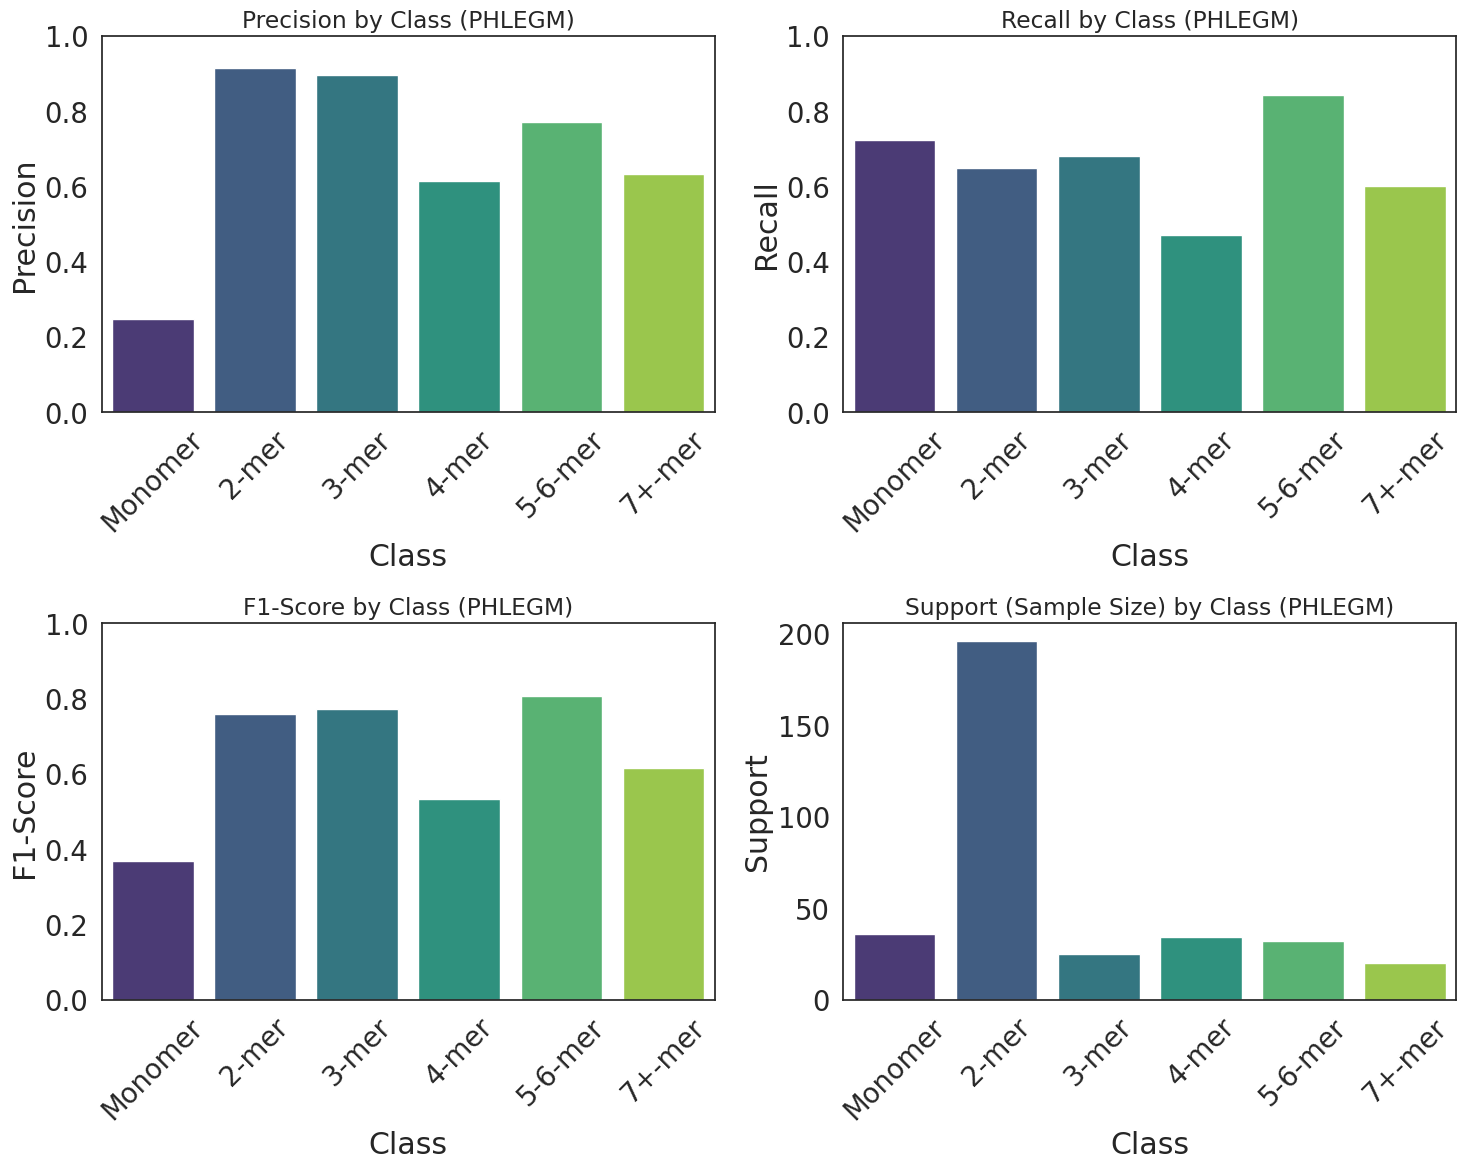

In [15]:
# Create bar plots for per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.set(style='white', font_scale=1.4)

# Define the desired order for classes
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']
phlegm_class_metrics_ordered = phlegm_class_metrics.set_index('Class').reindex(desired_order).reset_index()
phlegm_class_metrics_ordered = phlegm_class_metrics_ordered.dropna()

# Precision
sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Precision by Class (PHLEGM)')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Recall
sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Recall by Class (PHLEGM)')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)

# F1-Score
sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='viridis')
axes[1,0].set_title('F1-Score by Class (PHLEGM)')
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='x', rotation=45)

# Support (sample sizes)
sns.barplot(data=phlegm_class_metrics_ordered, x='Class', y='Support', ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Support (Sample Size) by Class (PHLEGM)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/phlegm_per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

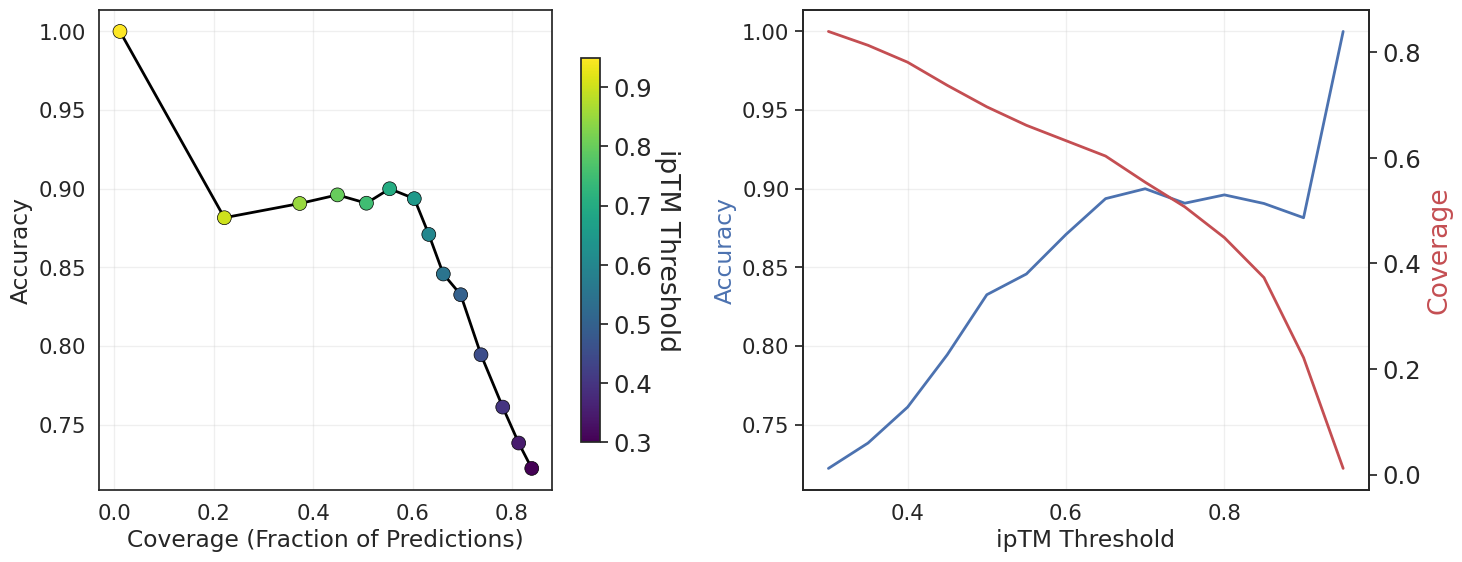

Best accuracy-coverage balance at threshold 0.65:
Accuracy: 0.894
Coverage: 0.603


In [16]:
# Threshold analysis for PHLEGM predictions
thresholds = np.arange(0.3, 1.0, 0.05)
threshold_results = []

for threshold in thresholds:
    # Apply threshold - predictions below threshold are considered "uncertain"
    df_threshold = df_phlegm.copy()
    df_threshold['confident_prediction'] = df_threshold['max_iptm'] >= threshold
    
    # Calculate metrics only for confident predictions
    confident_predictions = df_threshold[df_threshold['confident_prediction']]
    
    if len(confident_predictions) > 0:
        accuracy = accuracy_score(confident_predictions['curated_state_bin'], 
                                confident_predictions['prediction_state_bin'])
        coverage = len(confident_predictions) / len(df_threshold)
        
        threshold_results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'coverage': coverage,
            'n_predictions': len(confident_predictions)
        })

threshold_df = pd.DataFrame(threshold_results)

# Plot threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set(style='white', font_scale=1.6)

# Plot accuracy vs coverage trade-off with color gradient
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create color map for thresholds
norm = colors.Normalize(vmin=threshold_df['threshold'].min(), vmax=threshold_df['threshold'].max())
colormap = cm.viridis

# Plot with color gradient - line first, then scatter points on top
# Plot the connecting line first (so it appears behind the points)
axes[0].plot(threshold_df['coverage'], threshold_df['accuracy'], '-', 
             color='black', alpha=1.0, linewidth=2, zorder=1)
# Then plot the scatter points on top with higher z-order
scatter = axes[0].scatter(threshold_df['coverage'], threshold_df['accuracy'], 
                         c=threshold_df['threshold'], cmap=colormap, s=100, 
                         edgecolors='black', linewidth=0.5, zorder=2)
axes[0].set_xlabel('Coverage (Fraction of Predictions)')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)

# Add colorbar for threshold values
cbar = plt.colorbar(scatter, ax=axes[0], shrink=0.8)
cbar.set_label('ipTM Threshold', rotation=270, labelpad=20)

# Plot both metrics vs threshold
ax2 = axes[1].twinx()
line1 = axes[1].plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', linewidth=2, label='Accuracy')
line2 = ax2.plot(threshold_df['threshold'], threshold_df['coverage'], 'r-', linewidth=2, label='Coverage')

axes[1].set_xlabel('ipTM Threshold')
axes[1].set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Coverage', color='r')
axes[1].grid(True, alpha=0.3)

# Legend removed to prevent overlapping

plt.tight_layout()
plt.savefig('../figures/phlegm_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best accuracy-coverage balance at threshold {threshold_df.loc[threshold_df.index[len(threshold_df)//2], 'threshold']:.2f}:")
print(f"Accuracy: {threshold_df.loc[threshold_df.index[len(threshold_df)//2], 'accuracy']:.3f}")
print(f"Coverage: {threshold_df.loc[threshold_df.index[len(threshold_df)//2], 'coverage']:.3f}")

## repeat this procedure using the QUEEN method

In [ ]:
queen_predictions = pd.read_csv('/home/grig0076/GitHubs/phlegm/notebooks/queen_phrog_validation_set_predictions.tsv', sep='\t')

In [17]:
# great a dictionary to make bins 
bins_num_subunits = {1: 'Monomer', 
                2: '2-mer', 
                3: '3-mer',
                4: '4-mer', 
                5: '5-6-mer', 
                6: '5-6-mer', 
                7: '7+-mer', 
                8: '7+-mer',
                9: '7+-mer',
                10: '7+-mer',
                12: '7+-mer', 
                24: '7+-mer'}
queen_predictions['predicted_subunits_bin'] = [bins_num_subunits.get(s) for s in queen_predictions['num_subunits']]
queen_predictions['curated_state_bin'] = [state_bins_dict.get(phrogs_pass_alphafold_seen_state.get(p)) for p in queen_predictions['phrog']]

# You can now compare the 'mapped_symmetry' with the 'best_symmetry' to check if the predictions are correct
queen_predictions['prediction_score'] = (queen_predictions['predicted_subunits_bin'] == queen_predictions['curated_state_bin']).astype(int)
queen_predictions['is_correct'] = queen_predictions['prediction_score'] == 1
queen_predictions['correct_label'] = queen_predictions['is_correct'].map({True: "Correct", False: "Incorrect"})

NameError: name 'queen_predictions' is not defined

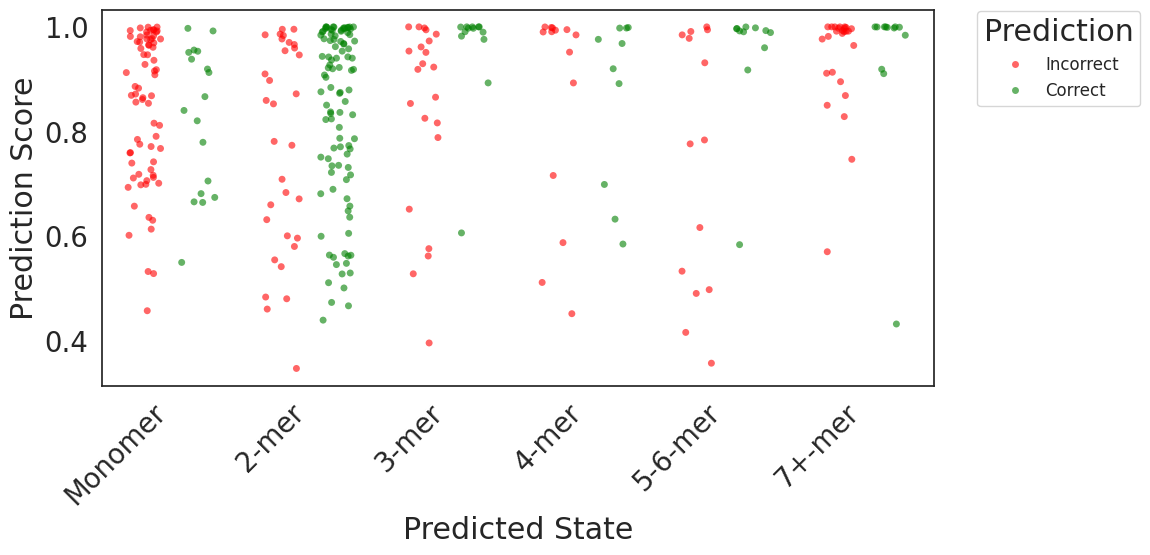

In [92]:
sns.set(style='white', font_scale=1.8)
plt.figure(figsize=(12, 6))

desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer'] 

# Create the stripplot
sns.stripplot(data=queen_predictions, x='predicted_subunits_bin', y='probability', hue='correct_label', dodge=True, jitter=0.25, alpha=0.6,
              palette={'Correct': 'green', 'Incorrect': 'red'},
              order=desired_order)


# Add legend
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/queen_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()


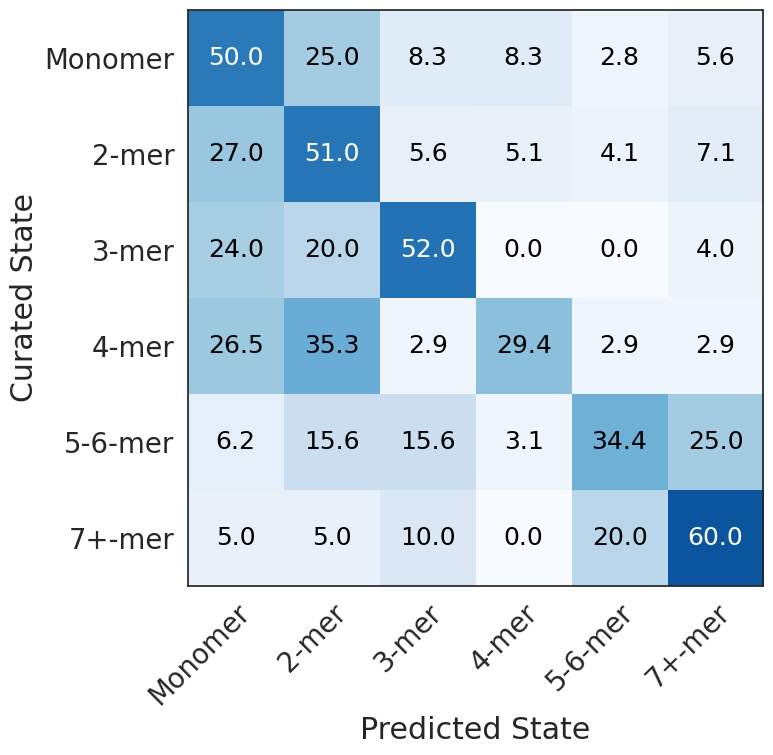

In [63]:
# make a confusion matrix of the predictions 
# Filter ambiguous rows (optional)
df = queen_predictions[queen_predictions['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['predicted_subunits_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)
# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Set color based on the score (adjust threshold if needed)
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/queen_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()

## make the same figures with predictions made using the seq2symm model 

In [94]:
# compare this with my curated states
symmetry_subunits = {'C1': 'Monomer',
 'C17': 'Homo 17-mer',
 'C2': 'Homo 2-mer',
 'C3': 'Homo 3-mer',
 'C4': 'Homo 4-mer',
 'C5': 'Homo 5-mer',
 'C6': 'Homo 6-mer',
 'C9': 'Homo 9-mer',
 'D2': 'Homo 4-mer',
 'D3': 'Homo 6-mer',
 'D4': 'Homo 8-mer',
 'D5': 'Homo 10-mer',
 'H': 'helical',
 'I': 'Homo 60-mer',
 'O': 'Homo 24-mer', 
 'T': 'Homo 12-mer'}  # changes these to higher order 


In [95]:
# Read the CSV file
seq2symm_results = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/monomers/seq2symmpredictions.csv')

# Convert the 'predicted_oligomerization_state' column from string representation to actual dictionary
seq2symm_results['predicted_oligomerization_state'] = seq2symm_results['predicted_oligomerization_state'].apply(literal_eval)

# Unpack the dictionary column into separate columns
oligomerization_columns = seq2symm_results['predicted_oligomerization_state'].apply(pd.Series)

# Join the unpacked columns back into the original dataframe
seq2symm_results = seq2symm_results.join(oligomerization_columns)

# Now, 'seq2symm_results' will have separate columns for each oligomerization state
print(seq2symm_results.head())

def get_best_symmetry(row):
    # Find the column with the highest score (ignoring NaNs)
    best_symmetry = row.dropna().idxmax()  # Get the column name (symmetry)
    best_score = row[best_symmetry]        # Get the corresponding score
    return pd.Series([best_symmetry, best_score], index=['best_symmetry', 'best_score'])

# Apply the function to each row (excluding 'fasta_id' and 'predicted_oligomerization_state')
best_symmetry_df = seq2symm_results.drop(columns=['fasta_id', 'predicted_oligomerization_state']).apply(get_best_symmetry, axis=1)

# Add 'fasta_id' to the new dataframe
best_symmetry_df['fasta_id'] = seq2symm_results['fasta_id']

# Reorder the columns so 'fasta_id' is the first column
best_symmetry_df = best_symmetry_df[['fasta_id', 'best_symmetry', 'best_score']]

# filter to only include ones in curated set 
best_symmetry_df = best_symmetry_df[best_symmetry_df['fasta_id'].isin(iptm_predictions['phrog'].to_list())] 
best_symmetry_df['curated_state_bin'] = [state_bins_dict.get(phrogs_pass_alphafold_seen_state.get(f)) for f in best_symmetry_df['fasta_id']]
best_symmetry_df['predicted_subunits_bin'] = [state_bins_dict.get(symmetry_subunits.get(c)) for c in best_symmetry_df['best_symmetry']] 

# mark whether the predictions are correct 
best_symmetry_df['prediction_score'] = (best_symmetry_df['predicted_subunits_bin'] == best_symmetry_df['curated_state_bin']).astype(int)
best_symmetry_df['is_correct'] = best_symmetry_df['prediction_score'] == 1
best_symmetry_df['correct_label'] = best_symmetry_df['is_correct'].map({True: "Correct", False: "Incorrect"})

      fasta_id                    predicted_oligomerization_state      C1  \
0   phrog_1004  {'C1': 0.5384, 'C3': 0.1549, 'D3': 0.1014, 'C2...  0.5384   
1  phrog_10132                       {'C2': 0.8364, 'D2': 0.1422}     NaN   
2   phrog_1017  {'C1': 0.7676, 'C2': 0.1615, 'D3': 0.026, 'C3'...  0.7676   
3    phrog_102  {'C1': 0.6135, 'C2': 0.3076, 'D3': 0.034, 'C3'...  0.6135   
4  phrog_10365  {'C2': 0.4824, 'C1': 0.3358, 'C4': 0.0359, 'D2...  0.3358   

       C3      D3      C2     C6      C5     C17       I      D2      C4  \
0  0.1549  0.1014  0.0575  0.052  0.0273  0.0157  0.0117  0.0109     NaN   
1     NaN     NaN  0.8364    NaN     NaN     NaN     NaN  0.1422     NaN   
2  0.0119  0.0260  0.1615    NaN     NaN     NaN     NaN  0.0109  0.0118   
3  0.0139  0.0340  0.3076    NaN     NaN     NaN     NaN     NaN  0.0115   
4  0.0109  0.0288  0.4824    NaN     NaN     NaN  0.0102  0.0346  0.0359   

       D4  C9   O  D12   H   T  D5  
0     NaN NaN NaN  NaN NaN NaN NaN  
1     

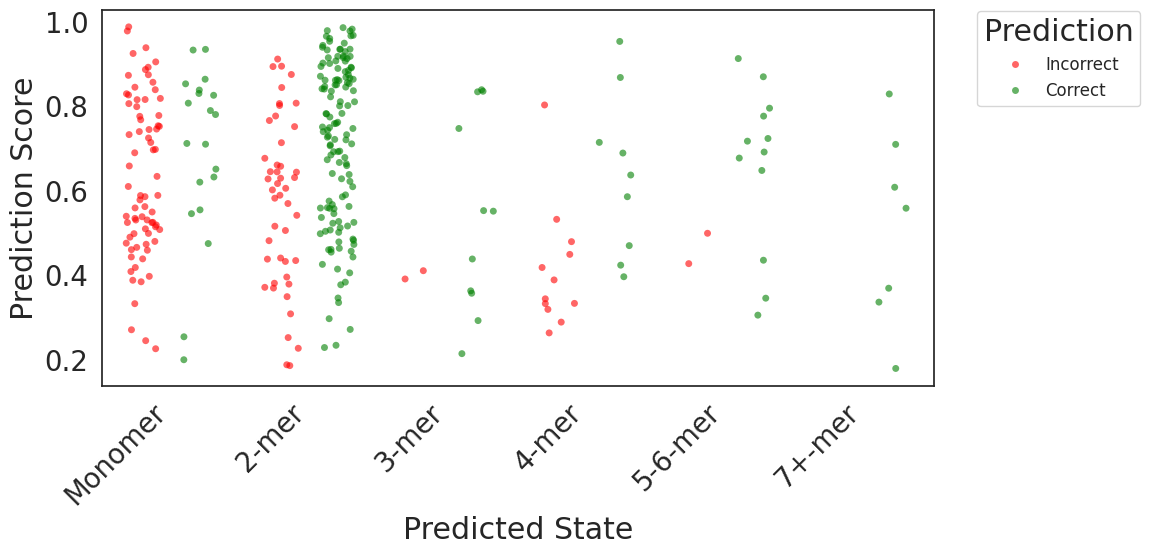

In [96]:
sns.set(style='white', font_scale=1.8)
plt.figure(figsize=(12, 6))

desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer'] 

# Create the stripplot
sns.stripplot(data=best_symmetry_df, x='predicted_subunits_bin', y='best_score', hue='correct_label', dodge=True, jitter=0.25, alpha=0.6,
              palette={'Correct': 'green', 'Incorrect': 'red'},
              order=desired_order)



# Add legend
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/seq2symm_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()


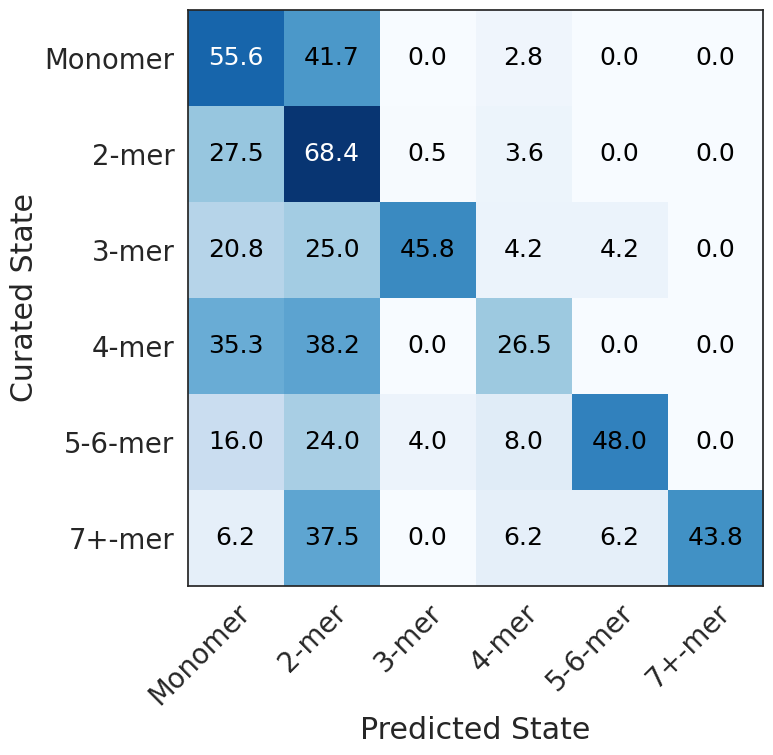

In [97]:
# make a confusion matrix of the predictions 
# Filter ambiguous rows (optional)
df = best_symmetry_df[best_symmetry_df['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['predicted_subunits_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)
# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Set color based on the score (adjust threshold if needed)
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/seq2symm_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()

## Detailed Metrics Analysis for QUEEN Method

In [43]:
# Compute additional metrics for QUEEN method
df_queen = queen_predictions[queen_predictions['curated_state_bin'] != 'ambiguous'].copy()

# Remove rows where either label is None
df_queen = df_queen[
    df_queen['curated_state_bin'].notnull() & df_queen['predicted_subunits_bin'].notnull()
]

# Get the classification report
y_true_queen = df_queen['curated_state_bin']
y_pred_queen = df_queen['predicted_subunits_bin']

print("QUEEN Method - Classification Report:")
print("="*50)
report_queen = classification_report(y_true_queen, y_pred_queen, output_dict=True)
print(classification_report(y_true_queen, y_pred_queen))

# Calculate overall accuracy
overall_accuracy_queen = accuracy_score(y_true_queen, y_pred_queen)
print(f"\nOverall Accuracy: {overall_accuracy_queen:.3f}")

# Calculate macro and micro averages
precision_macro_queen, recall_macro_queen, f1_macro_queen, _ = precision_recall_fscore_support(y_true_queen, y_pred_queen, average='macro')
precision_micro_queen, recall_micro_queen, f1_micro_queen, _ = precision_recall_fscore_support(y_true_queen, y_pred_queen, average='micro')

print(f"Macro-averaged Precision: {precision_macro_queen:.3f}")
print(f"Macro-averaged Recall: {recall_macro_queen:.3f}")
print(f"Macro-averaged F1-score: {f1_macro_queen:.3f}")
print(f"Micro-averaged Precision: {precision_micro_queen:.3f}")
print(f"Micro-averaged Recall: {recall_micro_queen:.3f}")
print(f"Micro-averaged F1-score: {f1_micro_queen:.3f}")

# Store metrics for later comparison
queen_metrics = {
    'method': 'QUEEN',
    'accuracy': overall_accuracy_queen,
    'precision_macro': precision_macro_queen,
    'recall_macro': recall_macro_queen,
    'f1_macro': f1_macro_queen,
    'precision_micro': precision_micro_queen,
    'recall_micro': recall_micro_queen,
    'f1_micro': f1_micro_queen
}

QUEEN Method - Classification Report:
              precision    recall  f1-score   support

       2-mer       0.76      0.51      0.61       196
       3-mer       0.37      0.52      0.43        25
       4-mer       0.42      0.29      0.34        34
     5-6-mer       0.44      0.34      0.39        32
      7+-mer       0.32      0.60      0.41        20
     Monomer       0.20      0.50      0.29        36

    accuracy                           0.48       343
   macro avg       0.42      0.46      0.41       343
weighted avg       0.58      0.48      0.50       343


Overall Accuracy: 0.478
Macro-averaged Precision: 0.417
Macro-averaged Recall: 0.461
Macro-averaged F1-score: 0.413
Micro-averaged Precision: 0.478
Micro-averaged Recall: 0.478
Micro-averaged F1-score: 0.478



Per-class metrics for QUEEN:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.758   0.510     0.610      196
1    3-mer      0.371   0.520     0.433       25
2    4-mer      0.417   0.294     0.345       34
3  5-6-mer      0.440   0.344     0.386       32
4   7+-mer      0.316   0.600     0.414       20
5  Monomer      0.202   0.500     0.288       36

Per-class metrics for QUEEN:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.758   0.510     0.610      196
1    3-mer      0.371   0.520     0.433       25
2    4-mer      0.417   0.294     0.345       34
3  5-6-mer      0.440   0.344     0.386       32
4   7+-mer      0.316   0.600     0.414       20
5  Monomer      0.202   0.500     0.288       36


/tmp/ipykernel_142974/671452822.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='plasma')
/tmp/ipykernel_142974/671452822.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='plasma')
/tmp/ipykernel_142974/671452822.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='plasma')
/tmp/ipykernel_14297


Per-class metrics for QUEEN:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.758   0.510     0.610      196
1    3-mer      0.371   0.520     0.433       25
2    4-mer      0.417   0.294     0.345       34
3  5-6-mer      0.440   0.344     0.386       32
4   7+-mer      0.316   0.600     0.414       20
5  Monomer      0.202   0.500     0.288       36


/tmp/ipykernel_142974/671452822.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='plasma')
/tmp/ipykernel_142974/671452822.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='plasma')
/tmp/ipykernel_142974/671452822.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=queen_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='plasma')
/tmp/ipykernel_14297

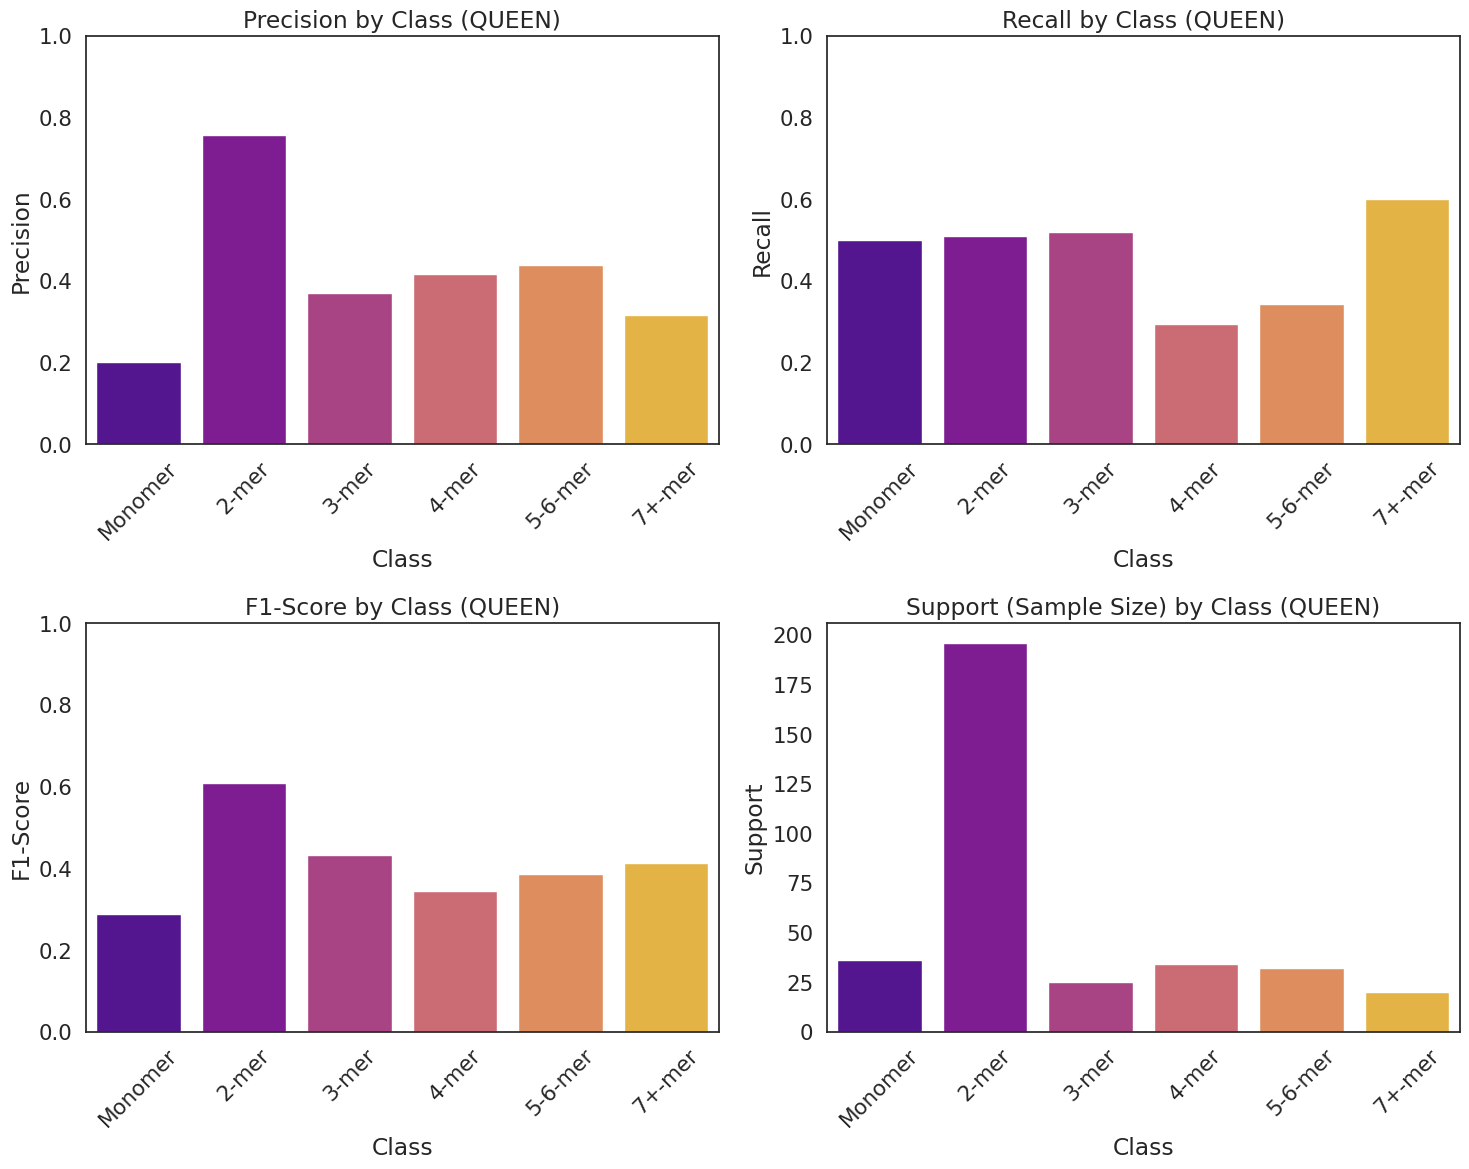

In [44]:
# Create a detailed per-class metrics table for QUEEN
metrics_data_queen = []
for class_name in report_queen.keys():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics_data_queen.append({
            'Class': class_name,
            'Precision': report_queen[class_name]['precision'],
            'Recall': report_queen[class_name]['recall'],
            'F1-Score': report_queen[class_name]['f1-score'],
            'Support': report_queen[class_name]['support']
        })

queen_class_metrics = pd.DataFrame(metrics_data_queen)
print("\nPer-class metrics for QUEEN:")
print(queen_class_metrics.round(3))

# Create bar plots for per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.set(style='white', font_scale=1.4)

# Define the desired order for classes
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']
queen_class_metrics_ordered = queen_class_metrics.set_index('Class').reindex(desired_order).reset_index()
queen_class_metrics_ordered = queen_class_metrics_ordered.dropna()

# Precision
sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='plasma')
axes[0,0].set_title('Precision by Class (QUEEN)')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Recall
sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='plasma')
axes[0,1].set_title('Recall by Class (QUEEN)')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)

# F1-Score
sns.barplot(data=queen_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='plasma')
axes[1,0].set_title('F1-Score by Class (QUEEN)')
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='x', rotation=45)

# Support (sample sizes)
sns.barplot(data=queen_class_metrics_ordered, x='Class', y='Support', ax=axes[1,1], palette='plasma')
axes[1,1].set_title('Support (Sample Size) by Class (QUEEN)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/queen_per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Detailed Metrics Analysis for seq2symm Method

In [45]:
# Compute additional metrics for seq2symm method
df_seq2symm = best_symmetry_df[best_symmetry_df['curated_state_bin'] != 'ambiguous'].copy()

# Drop rows where either label is None (to avoid sklearn errors)
df_seq2symm = df_seq2symm[
    df_seq2symm['curated_state_bin'].notnull() & df_seq2symm['predicted_subunits_bin'].notnull()
]

# Get the classification report
y_true_seq2symm = df_seq2symm['curated_state_bin']
y_pred_seq2symm = df_seq2symm['predicted_subunits_bin']

print("seq2symm Method - Classification Report:")
print("="*50)
report_seq2symm = classification_report(y_true_seq2symm, y_pred_seq2symm, output_dict=True)
print(classification_report(y_true_seq2symm, y_pred_seq2symm))

# Calculate overall accuracy
overall_accuracy_seq2symm = accuracy_score(y_true_seq2symm, y_pred_seq2symm)
print(f"\nOverall Accuracy: {overall_accuracy_seq2symm:.3f}")

# Calculate macro and micro averages
precision_macro_seq2symm, recall_macro_seq2symm, f1_macro_seq2symm, _ = precision_recall_fscore_support(y_true_seq2symm, y_pred_seq2symm, average='macro')
precision_micro_seq2symm, recall_micro_seq2symm, f1_micro_seq2symm, _ = precision_recall_fscore_support(y_true_seq2symm, y_pred_seq2symm, average='micro')

print(f"Macro-averaged Precision: {precision_macro_seq2symm:.3f}")
print(f"Macro-averaged Recall: {recall_macro_seq2symm:.3f}")
print(f"Macro-averaged F1-score: {f1_macro_seq2symm:.3f}")
print(f"Micro-averaged Precision: {precision_micro_seq2symm:.3f}")
print(f"Micro-averaged Recall: {recall_micro_seq2symm:.3f}")
print(f"Micro-averaged F1-score: {f1_micro_seq2symm:.3f}")

# Store metrics for later comparison
seq2symm_metrics = {
    'method': 'seq2symm',
    'accuracy': overall_accuracy_seq2symm,
    'precision_macro': precision_macro_seq2symm,
    'recall_macro': recall_macro_seq2symm,
    'f1_macro': f1_macro_seq2symm,
    'precision_micro': precision_micro_seq2symm,
    'recall_micro': recall_micro_seq2symm,
    'f1_micro': f1_micro_seq2symm
}

seq2symm Method - Classification Report:
              precision    recall  f1-score   support

       2-mer       0.74      0.68      0.71       193
       3-mer       0.85      0.46      0.59        24
       4-mer       0.43      0.26      0.33        34
     5-6-mer       0.86      0.48      0.62        25
      7+-mer       1.00      0.44      0.61        16
     Monomer       0.21      0.56      0.31        36

    accuracy                           0.58       328
   macro avg       0.68      0.48      0.53       328
weighted avg       0.68      0.58      0.61       328


Overall Accuracy: 0.582
Macro-averaged Precision: 0.681
Macro-averaged Recall: 0.480
Macro-averaged F1-score: 0.527
Micro-averaged Precision: 0.582
Micro-averaged Recall: 0.582
Micro-averaged F1-score: 0.582



Per-class metrics for seq2symm:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.742   0.684     0.712      193
1    3-mer      0.846   0.458     0.595       24
2    4-mer      0.429   0.265     0.327       34
3  5-6-mer      0.857   0.480     0.615       25
4   7+-mer      1.000   0.438     0.609       16
5  Monomer      0.211   0.556     0.305       36

Per-class metrics for seq2symm:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.742   0.684     0.712      193
1    3-mer      0.846   0.458     0.595       24
2    4-mer      0.429   0.265     0.327       34
3  5-6-mer      0.857   0.480     0.615       25
4   7+-mer      1.000   0.438     0.609       16
5  Monomer      0.211   0.556     0.305       36


/tmp/ipykernel_142974/2371730809.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='cividis')
/tmp/ipykernel_142974/2371730809.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='cividis')
/tmp/ipykernel_142974/2371730809.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='cividis')
/tmp/


Per-class metrics for seq2symm:
     Class  Precision  Recall  F1-Score  Support
0    2-mer      0.742   0.684     0.712      193
1    3-mer      0.846   0.458     0.595       24
2    4-mer      0.429   0.265     0.327       34
3  5-6-mer      0.857   0.480     0.615       25
4   7+-mer      1.000   0.438     0.609       16
5  Monomer      0.211   0.556     0.305       36


/tmp/ipykernel_142974/2371730809.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='cividis')
/tmp/ipykernel_142974/2371730809.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='cividis')
/tmp/ipykernel_142974/2371730809.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='cividis')
/tmp/

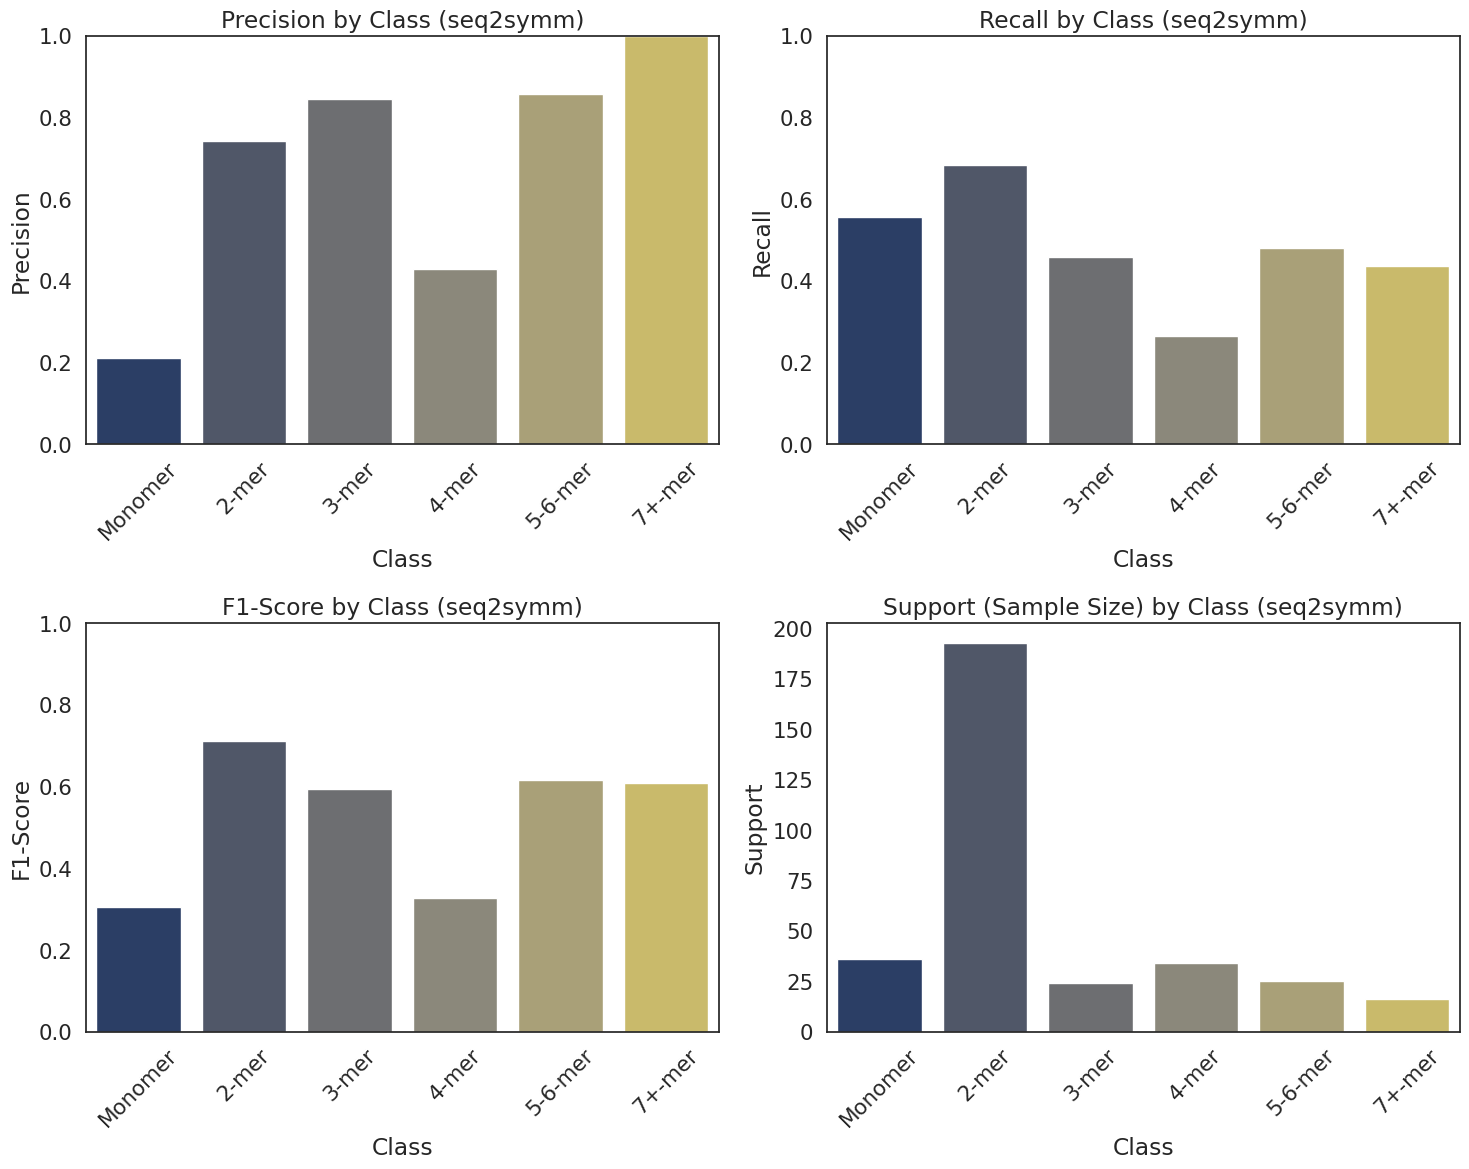

In [46]:
# Create a detailed per-class metrics table for seq2symm
metrics_data_seq2symm = []
for class_name in report_seq2symm.keys():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics_data_seq2symm.append({
            'Class': class_name,
            'Precision': report_seq2symm[class_name]['precision'],
            'Recall': report_seq2symm[class_name]['recall'],
            'F1-Score': report_seq2symm[class_name]['f1-score'],
            'Support': report_seq2symm[class_name]['support']
        })

seq2symm_class_metrics = pd.DataFrame(metrics_data_seq2symm)
print("\nPer-class metrics for seq2symm:")
print(seq2symm_class_metrics.round(3))

# Create bar plots for per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.set(style='white', font_scale=1.4)

# Define the desired order for classes
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']
seq2symm_class_metrics_ordered = seq2symm_class_metrics.set_index('Class').reindex(desired_order).reset_index()
seq2symm_class_metrics_ordered = seq2symm_class_metrics_ordered.dropna()

# Precision
sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Precision', ax=axes[0,0], palette='cividis')
axes[0,0].set_title('Precision by Class (seq2symm)')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Recall
sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Recall', ax=axes[0,1], palette='cividis')
axes[0,1].set_title('Recall by Class (seq2symm)')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)

# F1-Score
sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='F1-Score', ax=axes[1,0], palette='cividis')
axes[1,0].set_title('F1-Score by Class (seq2symm)')
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='x', rotation=45)

# Support (sample sizes)
sns.barplot(data=seq2symm_class_metrics_ordered, x='Class', y='Support', ax=axes[1,1], palette='cividis')
axes[1,1].set_title('Support (Sample Size) by Class (seq2symm)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../figures/seq2symm_per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Comparative Analysis of All Three Methods

Now let's compare the performance of PHLEGM, QUEEN, and seq2symm methods across different metrics.

Overall Performance Comparison:
     method  accuracy  precision_macro  recall_macro  f1_macro  \
0    PHLEGM     0.656            0.679         0.661     0.642   
1     QUEEN     0.478            0.417         0.461     0.413   
2  seq2symm     0.582            0.681         0.480     0.527   

   precision_micro  recall_micro  f1_micro  
0            0.656         0.656     0.656  
1            0.478         0.478     0.478  
2            0.582         0.582     0.582  


/tmp/ipykernel_142974/1218742270.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='accuracy', ax=axes[0,0], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
/tmp/ipykernel_142974/1218742270.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='f1_macro', ax=axes[0,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
/tmp/ipykernel_142974/1218742270.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='precision_macro', ax=axes[1,0], p

Overall Performance Comparison:
     method  accuracy  precision_macro  recall_macro  f1_macro  \
0    PHLEGM     0.656            0.679         0.661     0.642   
1     QUEEN     0.478            0.417         0.461     0.413   
2  seq2symm     0.582            0.681         0.480     0.527   

   precision_micro  recall_micro  f1_micro  
0            0.656         0.656     0.656  
1            0.478         0.478     0.478  
2            0.582         0.582     0.582  


/tmp/ipykernel_142974/1218742270.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='accuracy', ax=axes[0,0], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
/tmp/ipykernel_142974/1218742270.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='f1_macro', ax=axes[0,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
/tmp/ipykernel_142974/1218742270.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_metrics, x='method', y='precision_macro', ax=axes[1,0], p

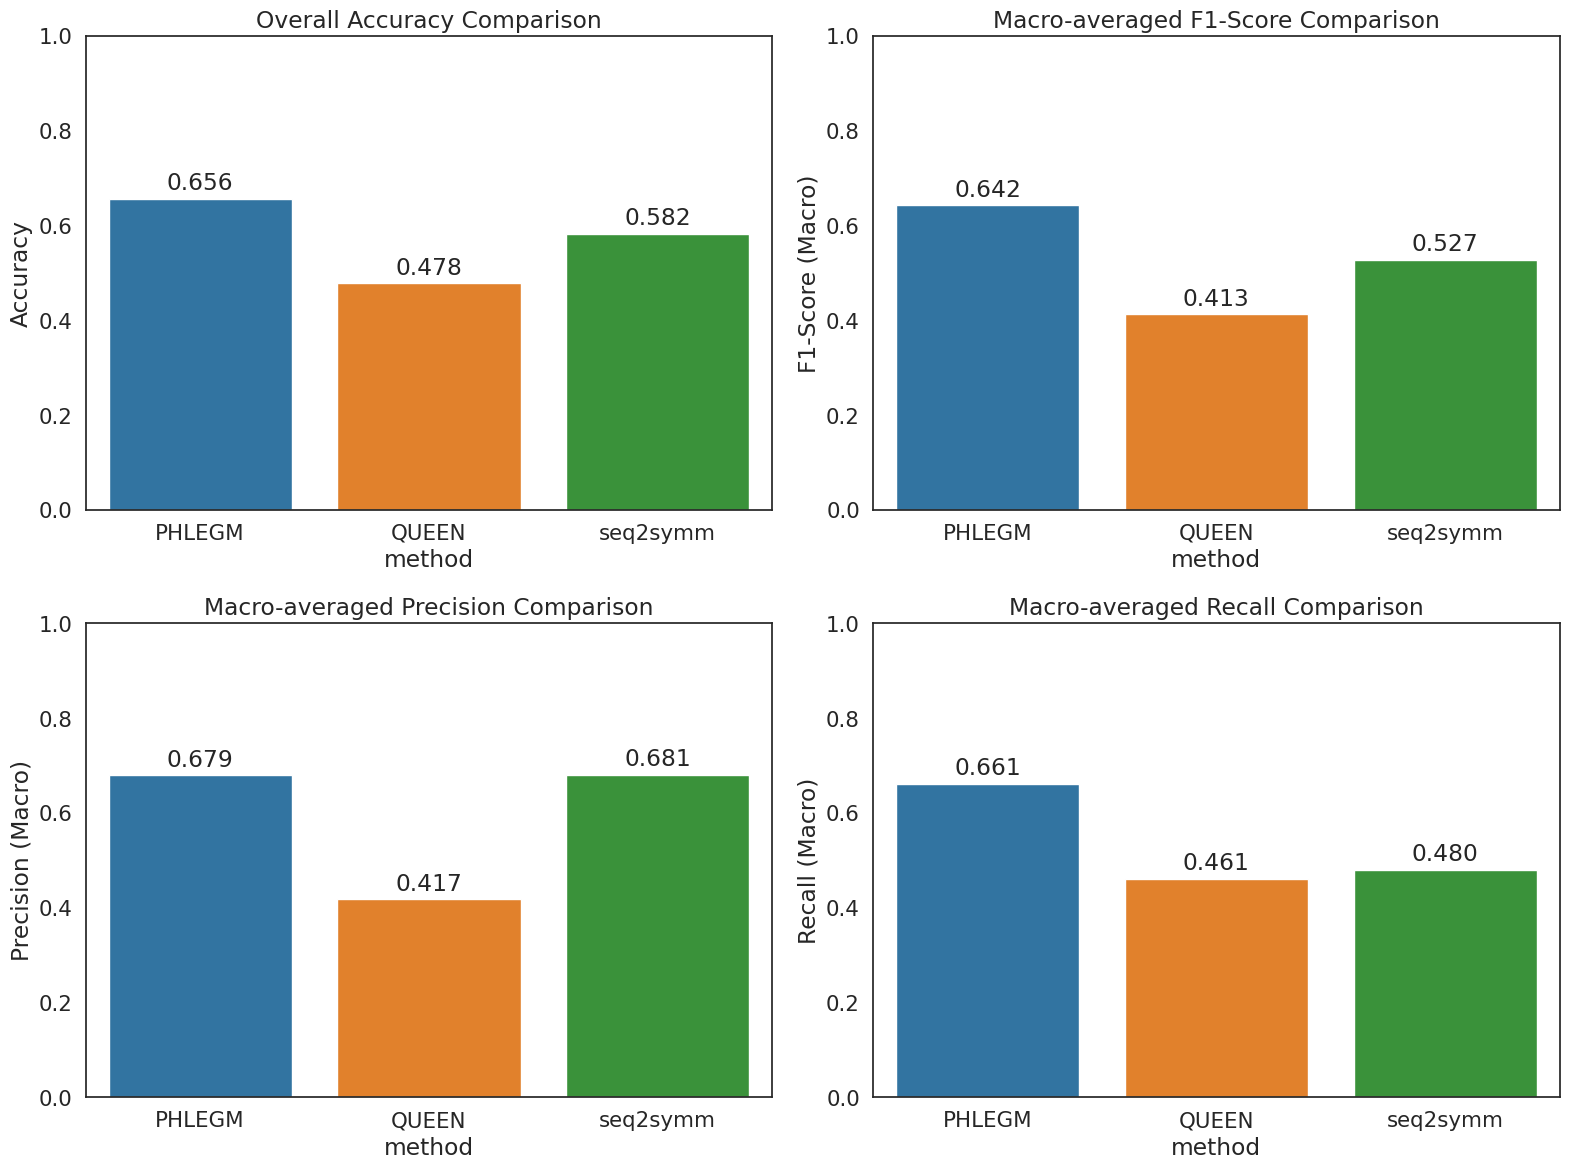

In [47]:
# Create comparison table of overall metrics
comparison_metrics = pd.DataFrame([phlegm_metrics, queen_metrics, seq2symm_metrics])
print("Overall Performance Comparison:")
print("="*60)
print(comparison_metrics.round(3))

# Create bar plot comparing overall metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style='white', font_scale=1.4)

# Accuracy
sns.barplot(data=comparison_metrics, x='method', y='accuracy', ax=axes[0,0], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0,0].set_title('Overall Accuracy Comparison')
axes[0,0].set_ylim(0, 1)
axes[0,0].set_ylabel('Accuracy')

# Macro F1-Score
sns.barplot(data=comparison_metrics, x='method', y='f1_macro', ax=axes[0,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0,1].set_title('Macro-averaged F1-Score Comparison')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_ylabel('F1-Score (Macro)')

# Macro Precision
sns.barplot(data=comparison_metrics, x='method', y='precision_macro', ax=axes[1,0], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1,0].set_title('Macro-averaged Precision Comparison')
axes[1,0].set_ylim(0, 1)
axes[1,0].set_ylabel('Precision (Macro)')

# Macro Recall
sns.barplot(data=comparison_metrics, x='method', y='recall_macro', ax=axes[1,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1,1].set_title('Macro-averaged Recall Comparison')
axes[1,1].set_ylim(0, 1)
axes[1,1].set_ylabel('Recall (Macro)')

# Add values on bars
for ax in axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('../figures/methods_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

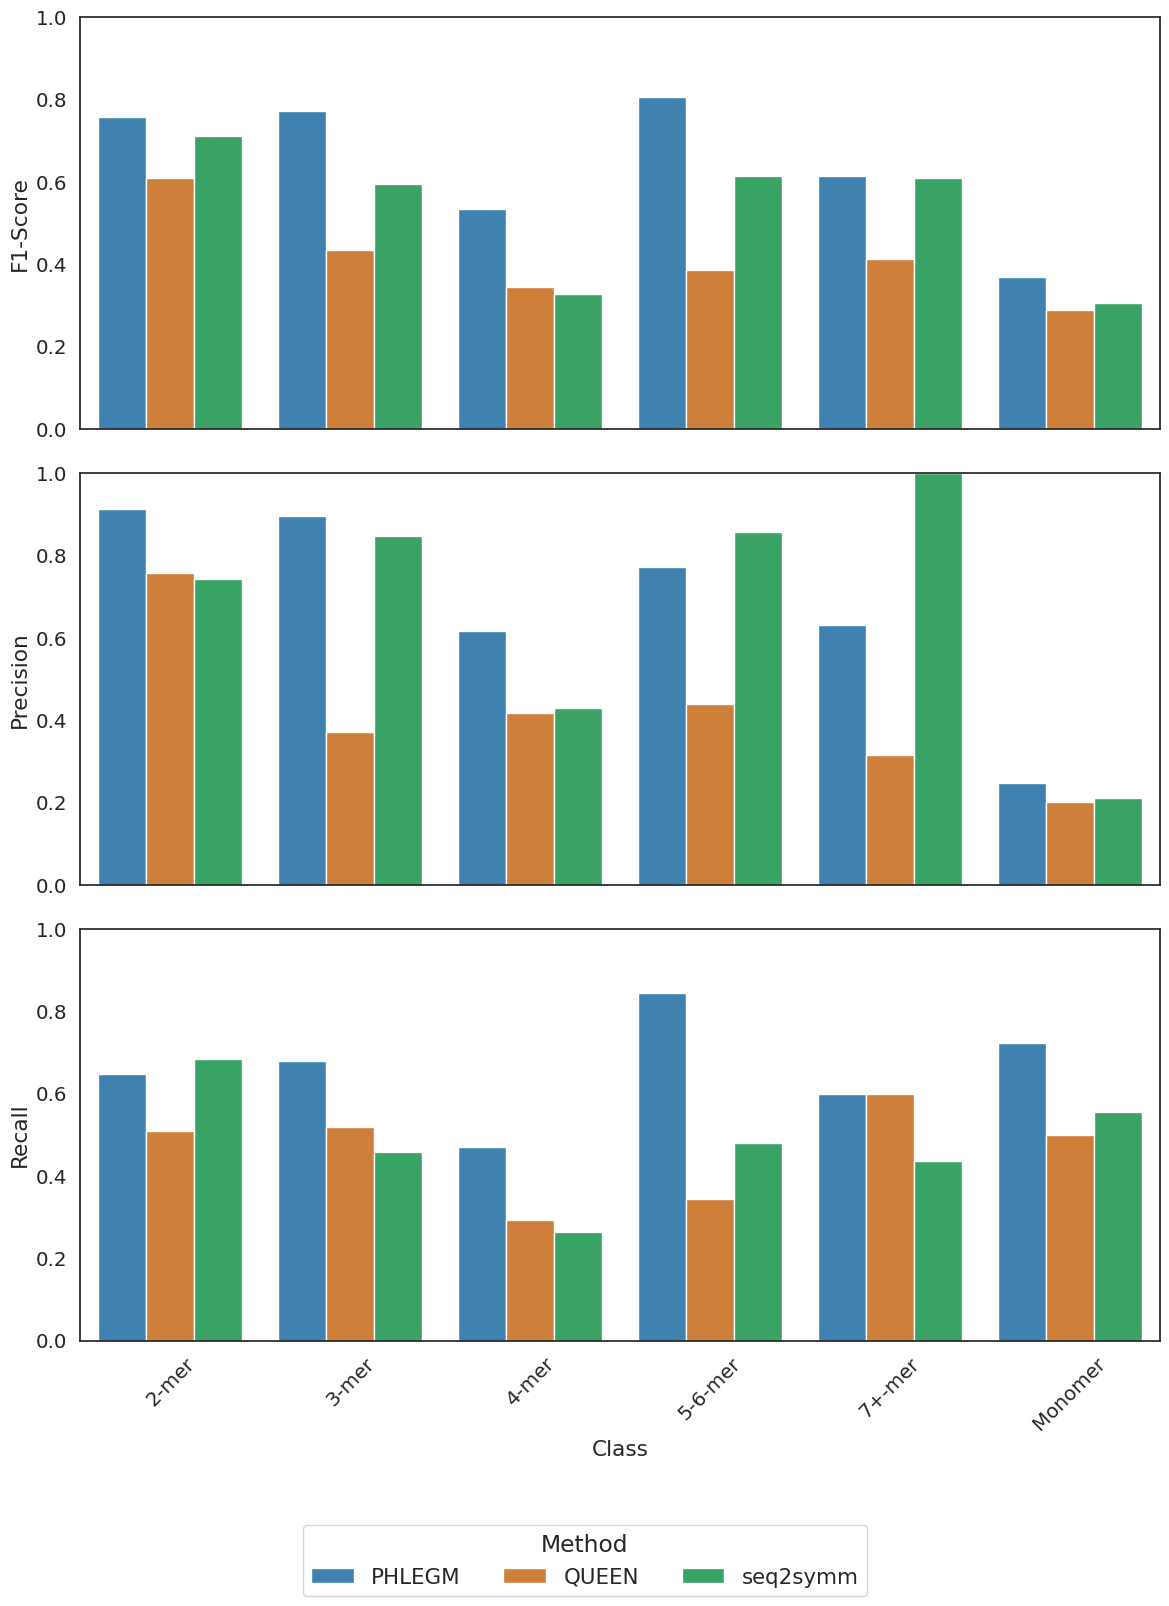

In [62]:
# Create per-class comparison across all methods
# Combine all per-class metrics
phlegm_class_metrics['Method'] = 'PHLEGM'
queen_class_metrics['Method'] = 'QUEEN'
seq2symm_class_metrics['Method'] = 'seq2symm'

all_class_metrics = pd.concat([phlegm_class_metrics, queen_class_metrics, seq2symm_class_metrics], ignore_index=True)

# Create comparison plots for per-class metrics with vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
sns.set(style='white', font_scale=1.4)


# Define a better color palette (professional and colorblind-friendly)
colors = ['#2E86C1', '#E67E22', '#28B463']  # Blue, Orange, Green

# F1-Score comparison by class
sns.barplot(data=all_class_metrics, x='Class', y='F1-Score', hue='Method', ax=axes[0], palette=colors)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].get_legend().remove()  # Remove individual legend

# Precision comparison by class
sns.barplot(data=all_class_metrics, x='Class', y='Precision', hue='Method', ax=axes[1], palette=colors)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].get_legend().remove()  # Remove individual legend

# Recall comparison by class
sns.barplot(data=all_class_metrics, x='Class', y='Recall', hue='Method', ax=axes[2], palette=colors)
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=45)
axes[2].get_legend().remove()  # Remove individual legend

# Add a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Method', bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=3)

plt.tight_layout()
plt.savefig('../figures/methods_per_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Analyze agreement between methods
# First, let's align the datasets to compare predictions on the same proteins
common_phrogs = set(df_phlegm['phrog']).intersection(
    set(df_queen['phrog'])).intersection(
    set(df_seq2symm['fasta_id']))

print(f"Number of proteins predicted by all three methods: {len(common_phrogs)}")

# Create aligned dataset
aligned_data = []
for phrog in common_phrogs:
    phlegm_pred = df_phlegm[df_phlegm['phrog'] == phrog]['prediction_state_bin'].iloc[0]
    queen_pred = df_queen[df_queen['phrog'] == phrog]['predicted_subunits_bin'].iloc[0]
    seq2symm_pred = df_seq2symm[df_seq2symm['fasta_id'] == phrog]['predicted_subunits_bin'].iloc[0]
    true_label = df_phlegm[df_phlegm['phrog'] == phrog]['curated_state_bin'].iloc[0]
    
    aligned_data.append({
        'phrog': phrog,
        'true_label': true_label,
        'PHLEGM': phlegm_pred,
        'QUEEN': queen_pred,
        'seq2symm': seq2symm_pred,
        'PHLEGM_correct': phlegm_pred == true_label,
        'QUEEN_correct': queen_pred == true_label,
        'seq2symm_correct': seq2symm_pred == true_label
    })

aligned_df = pd.DataFrame(aligned_data)

# Calculate pairwise agreement
phlegm_queen_agreement = (aligned_df['PHLEGM'] == aligned_df['QUEEN']).mean()
phlegm_seq2symm_agreement = (aligned_df['PHLEGM'] == aligned_df['seq2symm']).mean()
queen_seq2symm_agreement = (aligned_df['QUEEN'] == aligned_df['seq2symm']).mean()

print(f"\nPairwise Agreement Rates:")
print(f"PHLEGM vs QUEEN: {phlegm_queen_agreement:.3f}")
print(f"PHLEGM vs seq2symm: {phlegm_seq2symm_agreement:.3f}")
print(f"QUEEN vs seq2symm: {queen_seq2symm_agreement:.3f}")

# Calculate cases where all methods agree
all_agree = (aligned_df['PHLEGM'] == aligned_df['QUEEN']) & (aligned_df['QUEEN'] == aligned_df['seq2symm'])
all_agree_rate = all_agree.mean()
print(f"All three methods agree: {all_agree_rate:.3f}")

# When all agree, what's the accuracy?
all_agree_correct = aligned_df[all_agree]['PHLEGM_correct'].mean()
print(f"When all agree, accuracy: {all_agree_correct:.3f}")

# Create a summary table
agreement_summary = pd.DataFrame({
    'Method Pair': ['PHLEGM vs QUEEN', 'PHLEGM vs seq2symm', 'QUEEN vs seq2symm', 'All three methods'],
    'Agreement Rate': [phlegm_queen_agreement, phlegm_seq2symm_agreement, queen_seq2symm_agreement, all_agree_rate]
})

print(f"\nAgreement Summary:")
print(agreement_summary.round(3))

Number of proteins predicted by all three methods: 328

Pairwise Agreement Rates:
PHLEGM vs QUEEN: 0.534
PHLEGM vs seq2symm: 0.585
QUEEN vs seq2symm: 0.491
All three methods agree: 0.366
When all agree, accuracy: 0.792

Agreement Summary:
          Method Pair  Agreement Rate
0     PHLEGM vs QUEEN           0.534
1  PHLEGM vs seq2symm           0.585
2   QUEEN vs seq2symm           0.491
3   All three methods           0.366


/tmp/ipykernel_142974/816457627.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agreement_data, x='Comparison', y='Agreement Rate', ax=axes[0,0], palette='viridis')
/tmp/ipykernel_142974/816457627.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disagreement_df, x='Method', y='Accuracy_When_Disagreeing', ax=axes[1,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
/tmp/ipykernel_142974/816457627.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disagreement_df, x='Method', y='Accuracy_When_Disagreeing', ax=axes[1,1], p

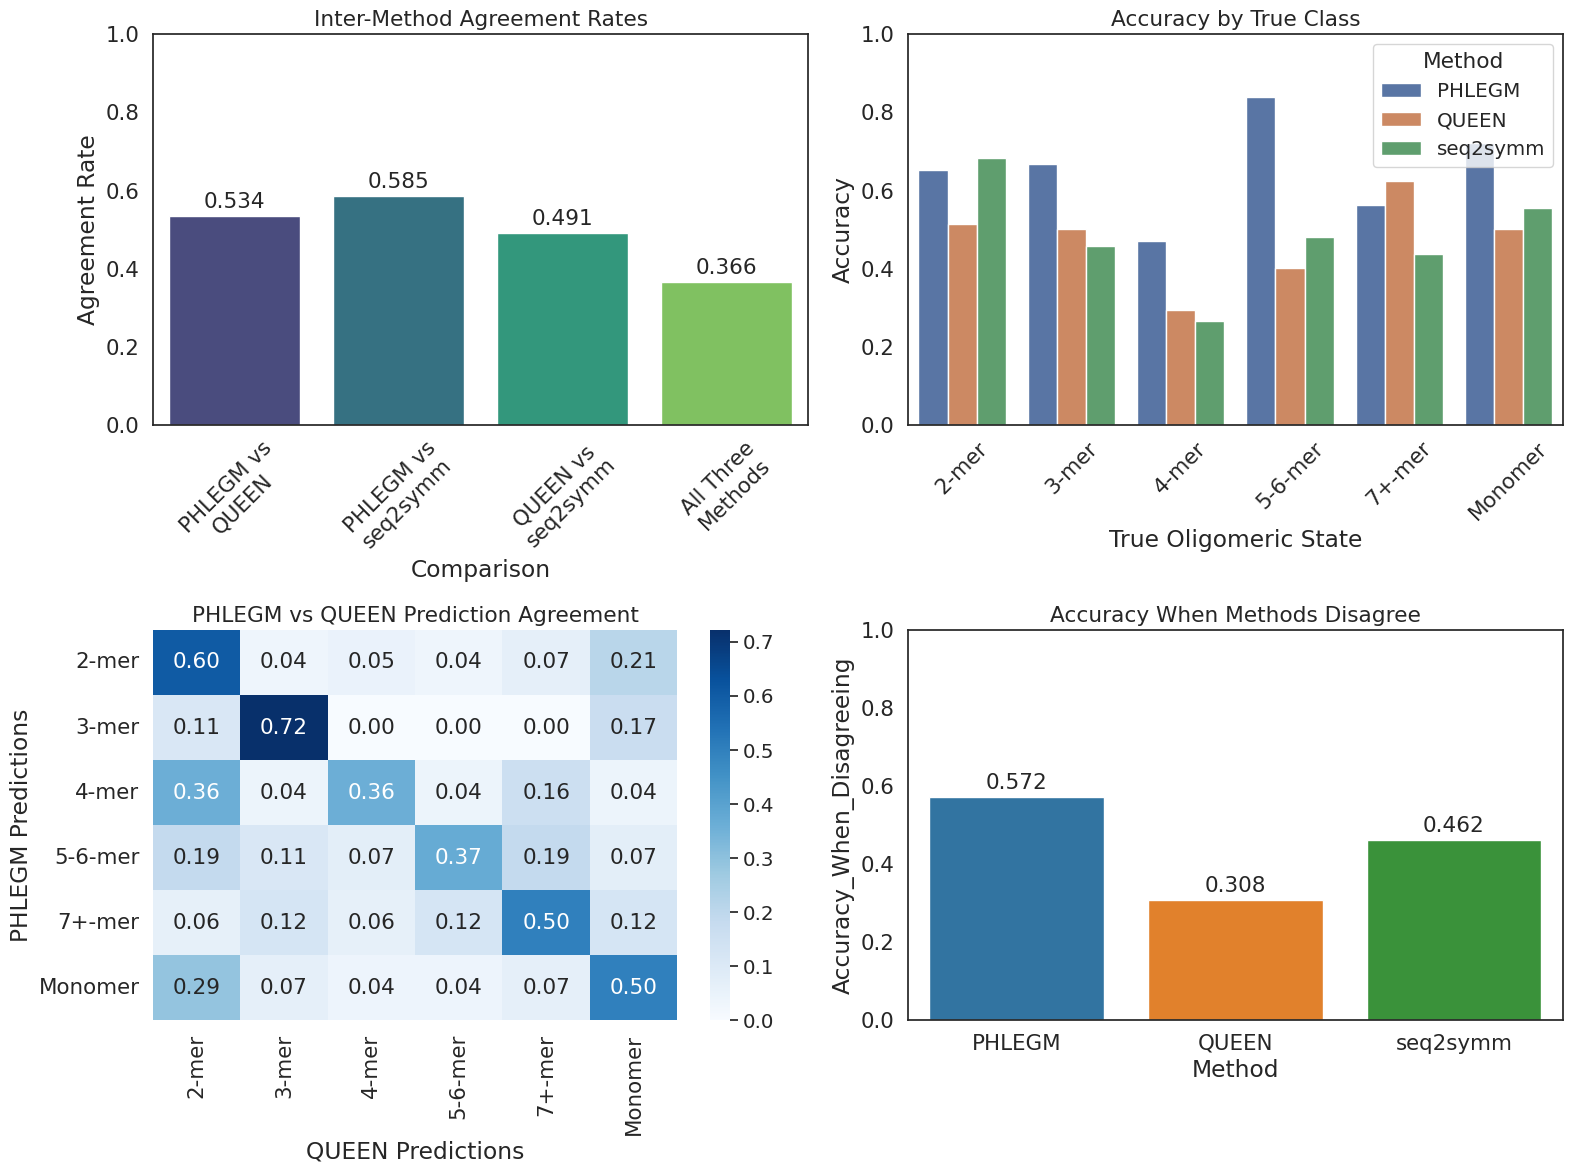

In [50]:
# Visualize agreement patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style='white', font_scale=1.3)

# Plot 1: Agreement rates
agreement_data = pd.DataFrame({
    'Comparison': ['PHLEGM vs\nQUEEN', 'PHLEGM vs\nseq2symm', 'QUEEN vs\nseq2symm', 'All Three\nMethods'],
    'Agreement Rate': [phlegm_queen_agreement, phlegm_seq2symm_agreement, queen_seq2symm_agreement, all_agree_rate]
})

sns.barplot(data=agreement_data, x='Comparison', y='Agreement Rate', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Inter-Method Agreement Rates')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Add values on bars
for container in axes[0,0].containers:
    axes[0,0].bar_label(container, fmt='%.3f', padding=3)

# Plot 2: Distribution of agreement by true class
agreement_by_class = aligned_df.groupby('true_label').agg({
    'PHLEGM_correct': 'mean',
    'QUEEN_correct': 'mean',
    'seq2symm_correct': 'mean'
}).reset_index()

agreement_by_class_melted = agreement_by_class.melt(id_vars='true_label', 
                                                    value_vars=['PHLEGM_correct', 'QUEEN_correct', 'seq2symm_correct'],
                                                    var_name='Method', value_name='Accuracy')
agreement_by_class_melted['Method'] = agreement_by_class_melted['Method'].str.replace('_correct', '')

sns.barplot(data=agreement_by_class_melted, x='true_label', y='Accuracy', hue='Method', ax=axes[0,1])
axes[0,1].set_title('Accuracy by True Class')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_xlabel('True Oligomeric State')

# Plot 3: Confusion matrix of PHLEGM vs QUEEN predictions
phlegm_queen_cm = pd.crosstab(aligned_df['PHLEGM'], aligned_df['QUEEN'], normalize='index')
sns.heatmap(phlegm_queen_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('PHLEGM vs QUEEN Prediction Agreement')
axes[1,0].set_xlabel('QUEEN Predictions')
axes[1,0].set_ylabel('PHLEGM Predictions')

# Plot 4: Cases where methods disagree but one is correct
disagreement_analysis = aligned_df[~all_agree].copy()
if len(disagreement_analysis) > 0:
    disagreement_correct = disagreement_analysis.agg({
        'PHLEGM_correct': 'mean',
        'QUEEN_correct': 'mean',
        'seq2symm_correct': 'mean'
    })
    
    disagreement_df = pd.DataFrame({
        'Method': ['PHLEGM', 'QUEEN', 'seq2symm'],
        'Accuracy_When_Disagreeing': disagreement_correct.values
    })
    
    sns.barplot(data=disagreement_df, x='Method', y='Accuracy_When_Disagreeing', ax=axes[1,1], palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1,1].set_title('Accuracy When Methods Disagree')
    axes[1,1].set_ylim(0, 1)
    
    # Add values on bars
    for container in axes[1,1].containers:
        axes[1,1].bar_label(container, fmt='%.3f', padding=3)
else:
    axes[1,1].text(0.5, 0.5, 'All methods agree\non all predictions', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Method Disagreement Analysis')

plt.tight_layout()
plt.savefig('../figures/method_agreement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Additional Classification Metrics and Visualizations

Let's compute additional metrics (precision, recall, F1-score, accuracy) for all three methods and create comparative visualizations.

In [54]:
# Summary of PHLEGM F1 scores and assessment
print("PHLEGM Method Performance Assessment:")
print("="*50)
print(f"Overall Accuracy: {phlegm_metrics['accuracy']:.3f}")
print(f"Macro-averaged F1-score: {phlegm_metrics['f1_macro']:.3f}")
print(f"Micro-averaged F1-score: {phlegm_metrics['f1_micro']:.3f}")

print(f"\nPer-class F1 scores:")
for _, row in phlegm_class_metrics.iterrows():
    print(f"{row['Class']:10}: {row['F1-Score']:.3f} (support: {row['Support']:3.0f})")

print(f"\nComparison with other methods:")
print(f"{'Method':<12} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Micro':<10}")
print("-" * 45)
for _, row in comparison_metrics.iterrows():
    print(f"{row['method']:<12} {row['accuracy']:<10.3f} {row['f1_macro']:<10.3f} {row['f1_micro']:<10.3f}")

# Assessment
print(f"\nAssessment of PHLEGM Performance:")
print("="*40)
if phlegm_metrics['f1_macro'] > 0.7:
    assessment = "EXCELLENT"
elif phlegm_metrics['f1_macro'] > 0.6:
    assessment = "GOOD" 
elif phlegm_metrics['f1_macro'] > 0.5:
    assessment = "MODERATE"
else:
    assessment = "POOR"
    
print(f"Overall F1-score rating: {assessment}")

# Compare to other methods
best_method = comparison_metrics.loc[comparison_metrics['f1_macro'].idxmax(), 'method']
if best_method == 'PHLEGM':
    print("✓ PHLEGM has the BEST macro F1-score among all methods!")
else:
    print(f"✗ {best_method} performs better with F1-macro of {comparison_metrics.loc[comparison_metrics['f1_macro'].idxmax(), 'f1_macro']:.3f}")

print(f"\nStrengths and weaknesses:")
best_class = phlegm_class_metrics.loc[phlegm_class_metrics['F1-Score'].idxmax(), 'Class']
worst_class = phlegm_class_metrics.loc[phlegm_class_metrics['F1-Score'].idxmin(), 'Class']
print(f"✓ Best performance: {best_class} (F1 = {phlegm_class_metrics['F1-Score'].max():.3f})")
print(f"✗ Worst performance: {worst_class} (F1 = {phlegm_class_metrics['F1-Score'].min():.3f})")

# Standards in the field
print(f"\nGeneral ML performance standards:")
print("F1 > 0.8: Excellent")
print("F1 > 0.7: Good") 
print("F1 > 0.6: Acceptable")
print("F1 > 0.5: Moderate")
print("F1 < 0.5: Poor")

PHLEGM Method Performance Assessment:
Overall Accuracy: 0.656
Macro-averaged F1-score: 0.642
Micro-averaged F1-score: 0.656

Per-class F1 scores:
2-mer     : 0.758 (support: 196)
3-mer     : 0.773 (support:  25)
4-mer     : 0.533 (support:  34)
5-6-mer   : 0.806 (support:  32)
7+-mer    : 0.615 (support:  20)
Monomer   : 0.369 (support:  36)

Comparison with other methods:
Method       Accuracy   F1-Macro   F1-Micro  
---------------------------------------------
PHLEGM       0.656      0.642      0.656     
QUEEN        0.478      0.413      0.478     
seq2symm     0.582      0.527      0.582     

Assessment of PHLEGM Performance:
Overall F1-score rating: GOOD
✓ PHLEGM has the BEST macro F1-score among all methods!

Strengths and weaknesses:
✓ Best performance: 5-6-mer (F1 = 0.806)
✗ Worst performance: Monomer (F1 = 0.369)

General ML performance standards:
F1 > 0.8: Excellent
F1 > 0.7: Good
F1 > 0.6: Acceptable
F1 > 0.5: Moderate
F1 < 0.5: Poor
